<a href="https://colab.research.google.com/github/tlacaelel666/projectalpha1/blob/main/ecuacionmaestralindblad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

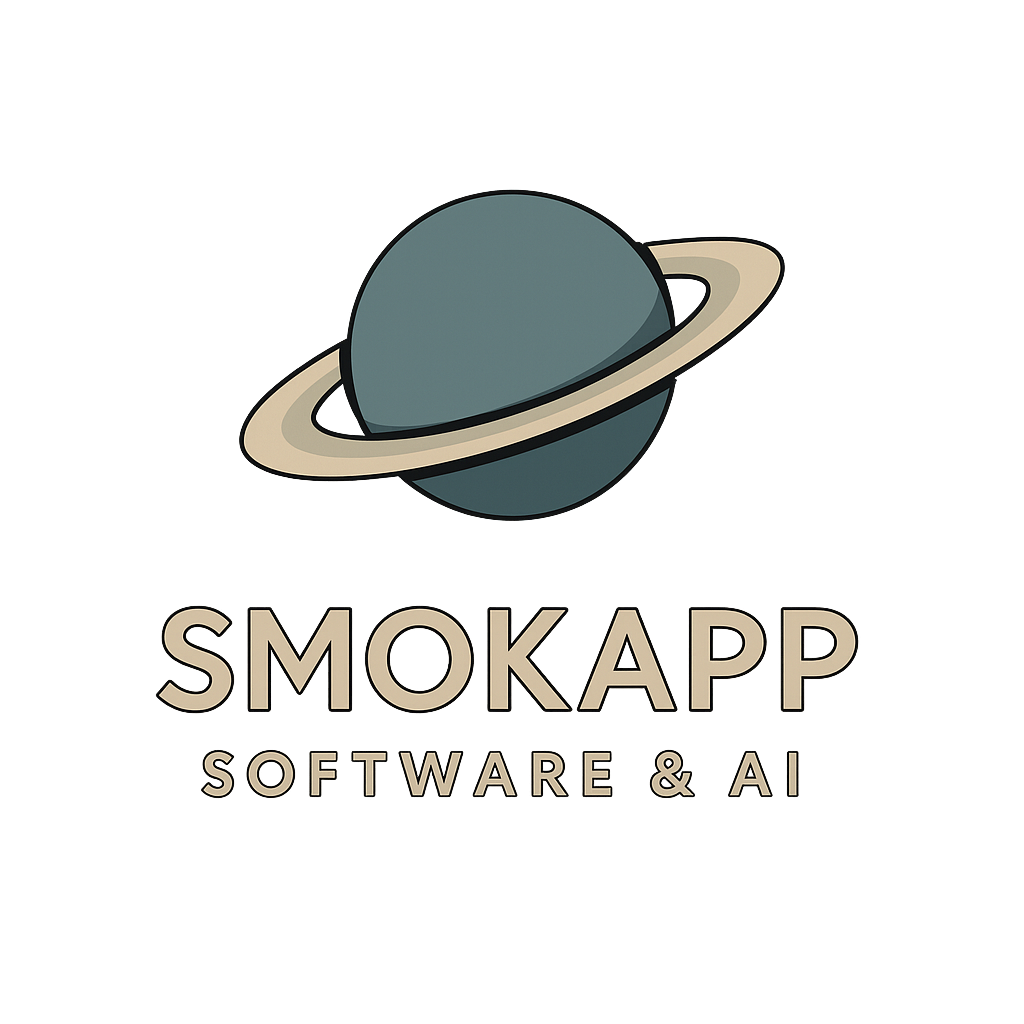

# Ecuación de Lindblad para Dinámica Cuántica
## Simulador by jako-smoQapp.software-&-AI
### Propósito

Este cuaderno de Google Colab presenta y utiliza un simulador en Python diseñado para modelar la dinámica temporal de sistemas cuánticos abiertos. El propósito principal es proporcionar una herramienta flexible y robusta para investigar los efectos de la decoherencia y la disipación en la evolución de la matriz de densidad de un sistema cuántico, regida por la Ecuación de Lindblad.

## Problema a Resolver

En la práctica, los sistemas cuánticos rara vez están perfectamente aislados de su entorno. Las interacciones con el entorno conducen a la pérdida de coherencia (decoherencia) y energía (disipación), fenómenos que son fundamentales para entender y controlar los sistemas cuánticos reales. El problema clave es simular con precisión esta dinámica no-unitaria para predecir el comportamiento de sistemas cuánticos bajo la influencia de su entorno.

Este simulador aborda este problema permitiendo:

*   Definir sistemas cuánticos arbitrarios mediante su Hamiltoniano y operadores de Lindblad.
*   Especificar condiciones iniciales y parámetros de simulación.
*   Resolver numéricamente la ecuación de Lindblad.
*   Calcular y visualizar la evolución de observables clave del sistema.
*   Analizar fenómenos específicos como el umbral de un láser.

## Resultados Esperados

Se espera que este cuaderno demuestre:

*   La capacidad del simulador para manejar diferentes sistemas cuánticos (qubit, oscilador, sistemas de decaimiento, láser).
*   La correcta evolución de la matriz de densidad y los observables bajo la influencia de la disipación y decoherencia.
*   La visualización clara de resultados como el decaimiento de coherencia, la relajación a un estado de equilibrio o estado estacionario (como en el caso del láser).
*   La identificación de características físicas importantes, como la transición de umbral en un sistema láser, mediante el barrido de parámetros.
*   Un código bien documentado y estructurado, fácil de entender y modificar para explorar nuevos sistemas y fenómenos.

In [1]:
# Instalación básica para visualización y arrays
%pip install numpy scipy matplotlib
print("Instalación de dependencias completa.")

Instalación de dependencias completa.


Configuración de estilo completa.
=== Simulador Robusto de Ecuación de Lindblad ===

1. Simulando qubit con relajación T1...
   ✓ Simulación exitosa (56 evaluaciones)


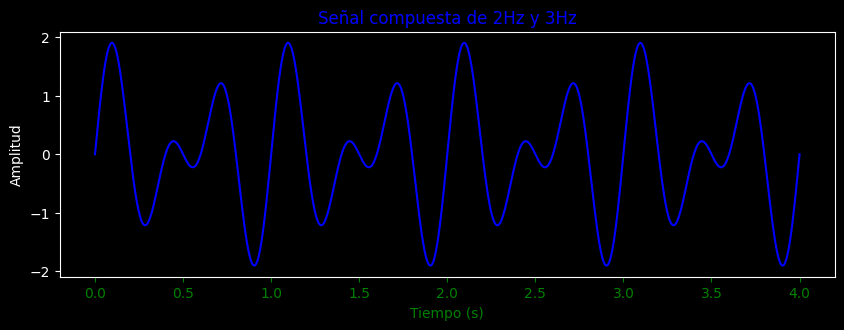

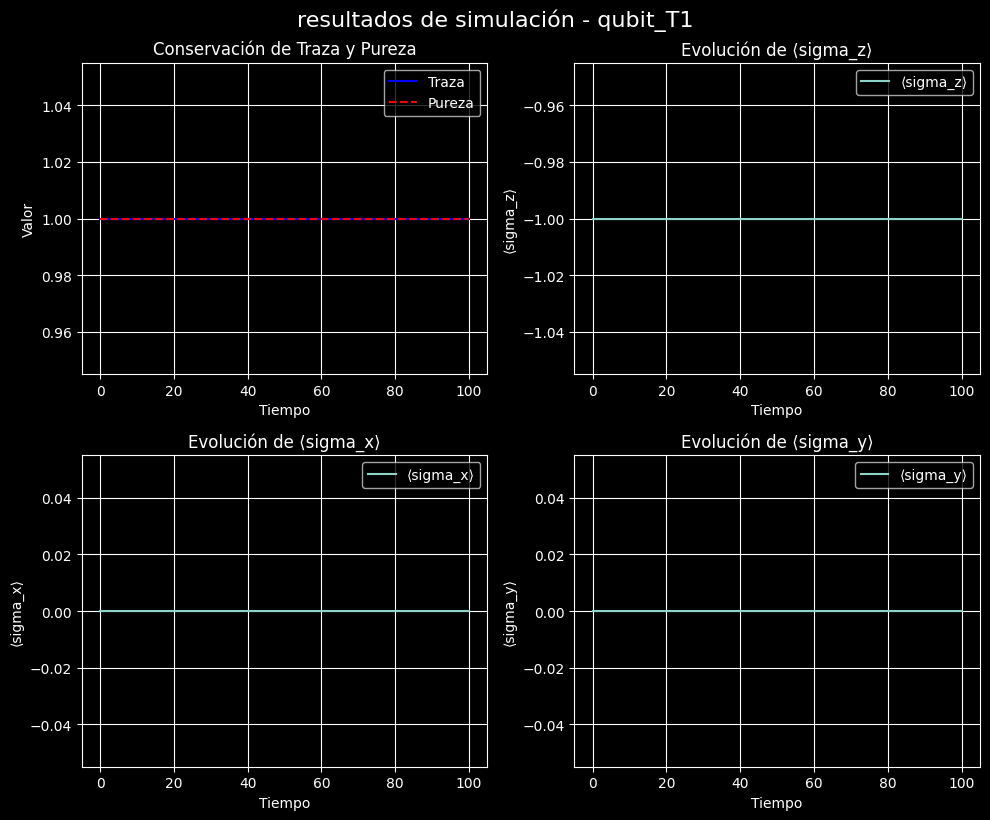


2. Simulando oscilador armónico con dephasing...
   ✓ Simulación exitosa (506 evaluaciones)


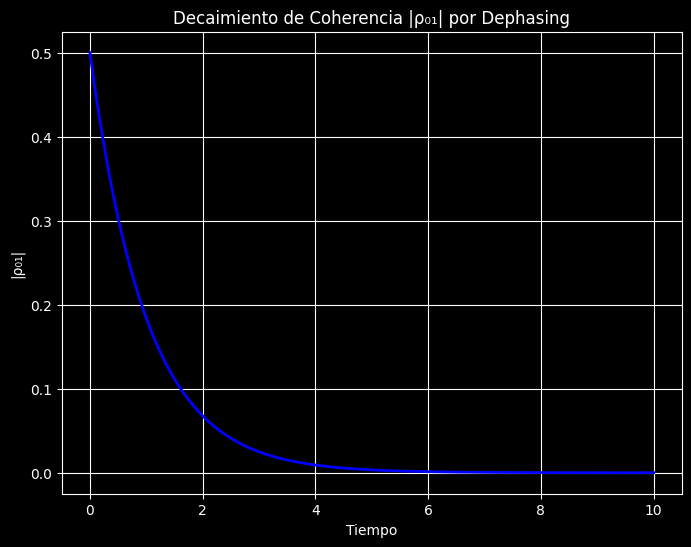

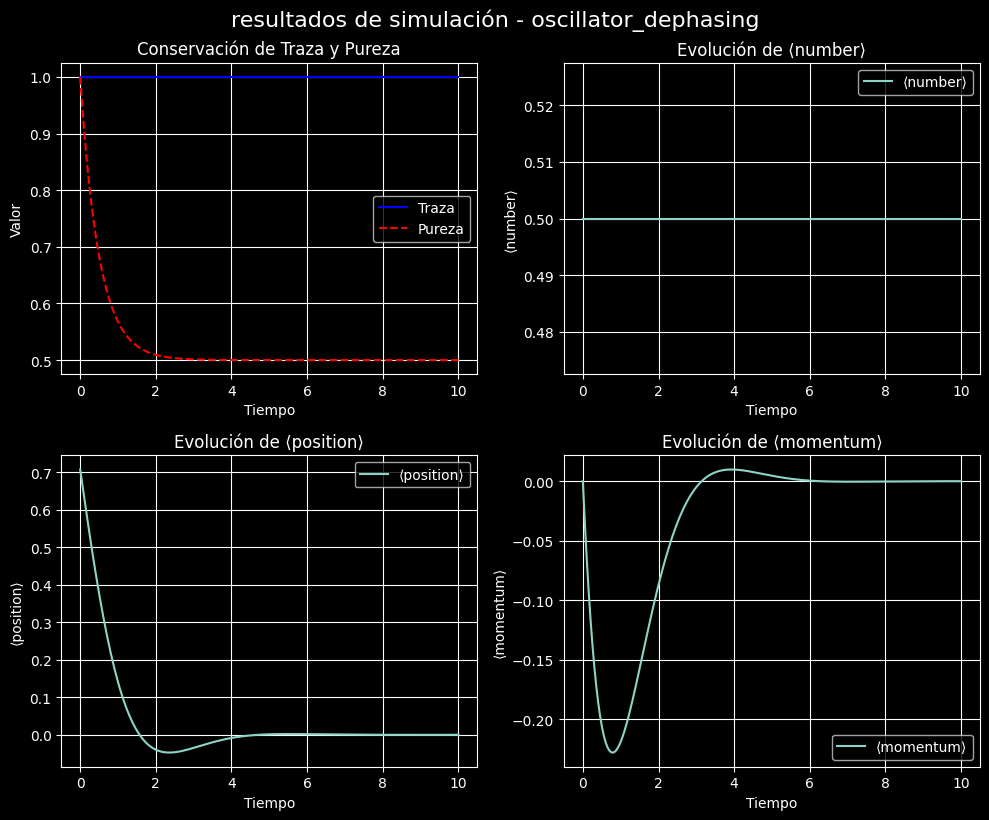


3. Simulando decaimiento de Tritio...
   ✓ Simulación exitosa (140 evaluaciones)


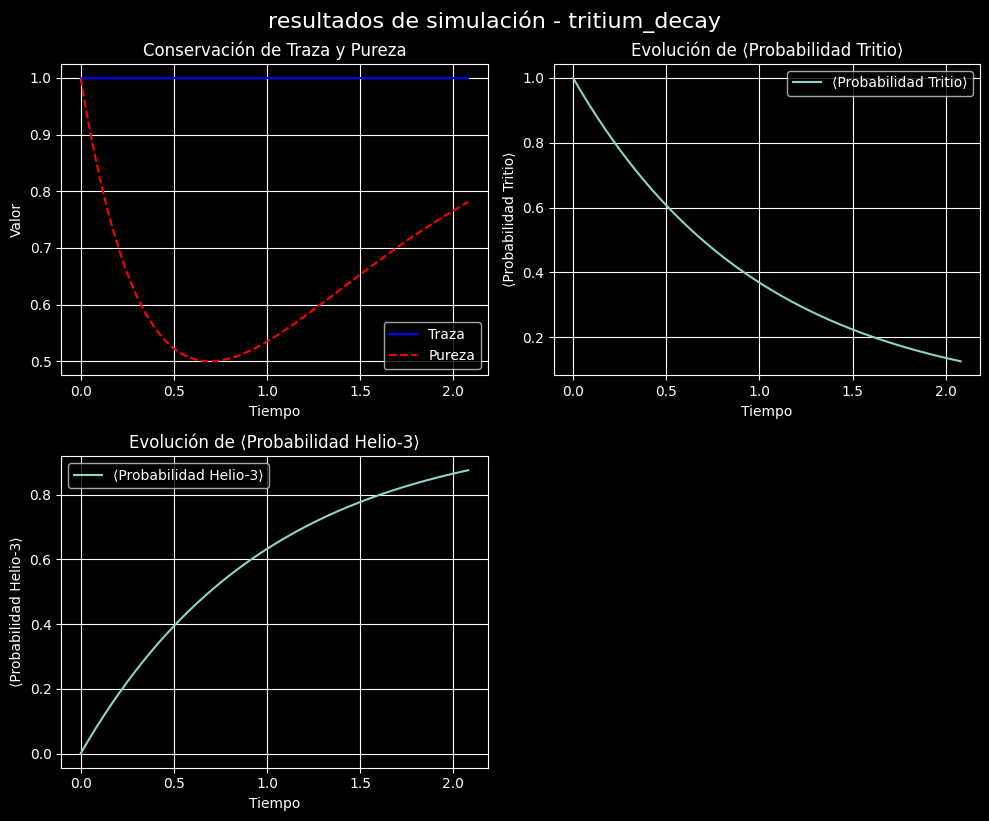

In [2]:
# -*- coding: utf-8 -*-
"""
Script para implementar el formalismo de la ecuación de Lindblad
para simular la dinámica de la matriz de densidad de un sistema cuántico.

Features ->
- Validación robusta de parámetros de entrada
- Manejo de errores y excepciones
- Logging para debugging y seguimiento
- Configuración flexible de parámetros
- Métodos de análisis avanzados
- Guardado/carga de resultados
- Visualizaciones mejoradas
- Documentación completa

Autor: Jacobo Tlacaelel Mina Rodriguez "jako"
Fecha: 2025
"""
# Llamado de importaciones
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import logging
import warnings
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Dict, Union
import pickle
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

import plotly.graph_objects as go

from plotly.subplots import make_subplots
import matplotlib.patches as patches



# Configurar el estilo para fondo oscuro

plt.style.use('dark_background')

print("Configuración de estilo completa.")
# Crear figura con subplots

fig = plt.figure(figsize=(10, 7))

fig.patch.set_facecolor('black')



# 1. GRÁFICA SUPERIOR: Señal en el tiempo (2Hz + 3Hz)

ax1 = plt.subplot(2, 2, (1, 2))

# Generar señal compuesta

t = np.linspace(0, 4, 1000)
signal_2hz = np.sin(2 * np.pi * 2 * t)
signal_3hz = np.sin(2 * np.pi * 3 * t)
combined_signal = signal_2hz + signal_3hz
ax1.plot(t, combined_signal, color='blue')
ax1.set_xlabel('Tiempo (s)', color='green')
ax1.set_ylabel('Amplitud', color='white')
ax1.tick_params(axis='x', colors='green')
ax1.tick_params(axis='y', colors='white')
ax1.set_title('Señal compuesta de 2Hz y 3Hz', color='blue')

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('lindblad_simulation.log'),
        plt.matplotlib.backends.backend_agg.FigureCanvasAgg # Add this line
        # logging.StreamHandler() # Comment or remove this line if you prefer to log to file only
    ]
)
logger = logging.getLogger(__name__)

# Configuraciones por defecto
@dataclass
class SimulationConfig:
    """Configuración para las simulaciones de Lindblad."""
    rtol: float = 1e-8
    atol: float = 1e-10
    max_step: Optional[float] = None
    method: str = 'RK45'
    dense_output: bool = False

    def validate(self):
        """Valida la configuración."""
        if self.rtol <= 0 or self.atol <= 0:
            raise ValueError("Las tolerancias deben ser positivas")
        if self.method not in ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']:
            raise ValueError(f"Método {self.method} no soportado")

# Parámetros del sistema el primer paso es la preparacion del hamiltoniano y los
# operadores de lindblad
@dataclass
class SystemParameters:
    """Parámetros base del sistema cuántico."""
    name: str
    dimension: int
    H: np.ndarray
    L_operators: List[np.ndarray]
    rho_0: np.ndarray
    t_span: Tuple[float, float]
    observables: Dict[str, np.ndarray] = field(default_factory=dict)

    def __post_init__(self):
        self.validate()

    def validate(self):
        """Valida todos los parámetros del sistema."""
        # Validar dimensiones
        if self.dimension <= 0:
            raise ValueError("La dimensión debe ser positiva")

        # Validar Hamiltoniano
        if self.H.shape != (self.dimension, self.dimension):
            raise ValueError(f"Hamiltoniano debe ser {self.dimension}x{self.dimension}")

        if not np.allclose(self.H, self.H.conj().T):
            warnings.warn("El Hamiltoniano no es Hermitiano", UserWarning)

        # Validar operadores de Lindblad
        for i, L in enumerate(self.L_operators):
            if L.shape != (self.dimension, self.dimension):
                raise ValueError(f"Operador Lindblad {i} debe ser {self.dimension}x{self.dimension}")

        # Validar matriz de densidad inicial
        if self.rho_0.shape != (self.dimension, self.dimension):
            raise ValueError(f"Matriz de densidad inicial debe ser {self.dimension}x{self.dimension}")

        if not np.allclose(self.rho_0, self.rho_0.conj().T):
            warnings.warn("La matriz de densidad inicial no es Hermitiana", UserWarning)

        trace = np.trace(self.rho_0)
        if not np.isclose(trace, 1.0):
            warnings.warn(f"La traza de rho_0 es {trace:.6f}, no 1.0", UserWarning)

        # Verificar que rho_0 es semidefinida positiva
        eigenvals = np.linalg.eigvals(self.rho_0)
        if np.any(eigenvals < -1e-10):
            warnings.warn("La matriz de densidad inicial no es semidefinida positiva", UserWarning)

        # Validar span de tiempo
        if self.t_span[1] <= self.t_span[0]:
            raise ValueError("El tiempo final debe ser mayor que el inicial")

# Nuevo dataclass para Cavity QED
@dataclass
class CavityQEDParameters:
    omega_a: float  # Frecuencia atómica
    omega_c: float  # Frecuencia de la cavidad
    g: float        # Constante de acoplamiento (frecuencia de Rabi)
    gamma: float    # Tasa de decaimiento atómico
    kappa: float    # Tasa de decaimiento de la cavidad
    N_max: int      # Número máximo de fotones de la cavidad (dimensión de Fock)
    N_atoms: int = 1 # Número de átomos (1 para Jaynes-Cummings)

    @property
    def cooperativity(self) -> float:
        """C = g^2 / (kappa * gamma)"""
        if self.kappa * self.gamma == 0:
            return float('inf')
        return (self.g**2) / (self.kappa * self.gamma)

    @property
    def purcell_factor(self) -> float:
        """Factor de Purcell = C para resonancia"""
        return self.cooperativity

    @property
    def coupling_regime(self) -> str:
        """Clasifica el régimen de acoplamiento"""
        if self.g > self.kappa and self.g > self.gamma:
            return "Fuerte"
        elif self.g < self.kappa and self.g < self.gamma:
            return "Débil"
        elif self.g > self.kappa and self.g < self.gamma:
            return "Mala Cavidad"
        elif self.g < self.kappa and self.g > self.gamma:
            return "Mal Átomo"
        return "Transición"


class LindladSimulator:
    """Simulador robusto para la ecuación de Lindblad."""

    def __init__(self, config: Optional[SimulationConfig] = None):
        """
        Inicializa el simulador.

        Args:
            config: Configuración de la simulación
        """
        self.config = config if config is not None else SimulationConfig()
        self.config.validate()
        self.results = {}
        logger.info("Simulador Lindblad inicializado")

    def lindblad_rhs(self, t: float, rho_vec: np.ndarray,
                    H: np.ndarray, L_operators: List[np.ndarray]) -> np.ndarray:
        """
        Función que define el lado derecho de la ecuación de Lindblad.

        Args:
            t: El tiempo actual
            rho_vec: La matriz de densidad aplanada (vectorizada)
            H: El Hamiltoniano del sistema
            L_operators: Lista de operadores de Lindblad

        Returns:
            El vector aplanado de la derivada de la matriz de densidad
        """
        try:
            # Desvectorizar la matriz de densidad
            n = int(np.sqrt(len(rho_vec)))
            rho = rho_vec.reshape((n, n))

            # Término de evolución coherente
            drho_dt = -1j * (H @ rho - rho @ H)

            # Términos de decoherencia (superoperador de disipación)
            for L in L_operators:
                L_dagger = L.conj().T
                drho_dt += (L @ rho @ L_dagger) - 0.5 * (L_dagger @ L @ rho + rho @ L_dagger @ L)

            return drho_dt.flatten()

        except Exception as e:
            logger.error(f"Error en lindblad_rhs en t={t}: {e}")
            raise

    def simulate(self, params: SystemParameters,
                t_eval: Optional[np.ndarray] = None) -> Dict:
        """
        Ejecuta la simulación de Lindblad.

        Args:
            params: Parámetros del sistema
            t_eval: Puntos de tiempo para evaluación

        Returns:
            Diccionario con los resultados
        """
        logger.info(f"Iniciando simulación para sistema: {params.name}")

        # Configurar puntos de evaluación
        if t_eval is None:
            t_eval = np.linspace(params.t_span[0], params.t_span[1], 100)

        try:
            # Resolver la ecuación diferencial
            solve_ivp_args = {
                'fun': self.lindblad_rhs,
                't_span': params.t_span,
                'y0': params.rho_0.flatten(),
                'args': (params.H, params.L_operators),
                't_eval': t_eval,
                'rtol': self.config.rtol,
                'atol': self.config.atol,
                'method': self.config.method,
                'dense_output': self.config.dense_output
            }

            if self.config.max_step is not None:
                solve_ivp_args['max_step'] = self.config.max_step

            sol = solve_ivp(**solve_ivp_args)


            if not sol.success:
                raise RuntimeError(f"Integración falló: {sol.message}")

            # Procesar resultados
            rho_t = np.array([s.reshape((params.dimension, params.dimension))
                            for s in sol.y.T])

            # Calcular observables
            observables = {}
            for obs_name, obs_op in params.observables.items():
                observables[obs_name] = [np.trace(rho @ obs_op) for rho in rho_t]

            # Métricas de calidad
            traces = [np.trace(rho).real for rho in rho_t]
            purities = [np.trace(rho @ rho).real for rho in rho_t]

            results = {
                'success': True,
                'name': params.name, # Include system name here
                'time': sol.t,
                'rho_t': rho_t,
                'observables': observables,
                'traces': traces,
                'purities': purities,
                'integration_info': {
                    'nfev': sol.nfev,
                    'njev': sol.njev,
                    'nlu': sol.nlu,
                    'status': sol.status,
                    'message': sol.message
                }
            }

            self.results[params.name] = results
            logger.info(f"Simulación completada para {params.name}")

            # Verificar conservación de la traza
            trace_variation = max(traces) - min(traces)
            if trace_variation > 1e-6:
                warnings.warn(f"Variación de traza: {trace_variation:.2e}")

            return results

        except Exception as e:
            logger.error(f"Error en simulación de {params.name}: {e}")
            return {'success': False, 'error': str(e)}

    def save_results(self, filename: str, format: str = 'pickle'):
        """
        Guarda los resultados de simulación.

        Args:
            filename: Nombre del archivo
            format: Formato ('pickle' o 'json')
        """
        try:
            if format == 'pickle':
                with open(filename, 'wb') as f:
                    pickle.dump(self.results, f)
            elif format == 'json':
                # Convertir arrays numpy para JSON
                json_results = {}
                for name, result in self.results.items():
                    if result.get('success', False):
                        json_results[name] = {
                            'time': result['time'].tolist(),
                            'traces': result['traces'],
                            'purities': result['purities'],
                            'observables': {k: np.real(v).tolist()
                                          for k, v in result['observables'].items()}
                        }
                with open(filename, 'w') as f:
                    json.dump(json_results, f, indent=2)

            logger.info(f"Resultados guardados en {filename}")
        except Exception as e:
            logger.error(f"Error guardando resultados: {e}")

    def load_results(self, filename: str, format: str = 'pickle'):
        """Carga resultados previamente guardados."""
        try:
            if format == 'pickle':
                with open(filename, 'rb') as f:
                    self.results = pickle.load(f)
            elif format == 'json':
                with open(filename, 'r') as f:
                    self.results = json.load(f)

            logger.info(f"Resultados cargados desde {filename}")
        except Exception as e:
            logger.error(f"Error cargando resultados: {e}")

def create_qubit_system() -> SystemParameters:
    """Crea un sistema de qubit con relajación T1."""

    # Parámetros del sistema
    omega_0 = 1.0
    gamma_t1 = 0.1

    # Operadores
    H_qubit = 0.5 * omega_0 * np.array([[1, 0], [0, -1]], dtype=complex)
    sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
    L_qubit = [np.sqrt(gamma_t1) * sigma_minus]

    # Estado inicial
    rho_0_qubit = np.array([[0, 0], [0, 1]], dtype=complex)

    # Observables
    observables = {
        'sigma_z': np.array([[1, 0], [0, -1]], dtype=complex),
        'sigma_x': np.array([[0, 1], [1, 0]], dtype=complex),
        'sigma_y': np.array([[0, -1j], [1j, 0]], dtype=complex)
    }

    return SystemParameters(
        name="qubit_T1",
        dimension=2,
        H=H_qubit,
        L_operators=L_qubit,
        rho_0=rho_0_qubit,
        t_span=(0, 10 / gamma_t1),
        observables=observables
    )

def create_oscillator_system(N: int = 5) -> SystemParameters:
    """Crea un sistema de oscilador armónico con dephasing."""

    # Parámetros del sistema
    omega_osc = 1.0
    gamma_deph = 0.5

    # Operadores
    a = np.diag(np.sqrt(np.arange(1, N)), k=1).astype(complex)
    adagger = a.conj().T
    H_osc = omega_osc * (adagger @ a)

    # Operador de dephasing
    P = np.diag([(-1)**n for n in range(N)]).astype(complex)
    L_osc = [np.sqrt(gamma_deph) * P]

    # Estado inicial: superposición
    psi_0 = np.zeros(N, dtype=complex)
    psi_0[0] = 1/np.sqrt(2)
    psi_0[1] = 1/np.sqrt(2)
    rho_0_osc = np.outer(psi_0, psi_0.conj())

    # Observables
    n_op = adagger @ a
    x_op = (a + adagger) / np.sqrt(2)
    p_op = -1j * (a - adagger) / np.sqrt(2)

    observables = {
        'number': n_op,
        'position': x_op,
        'momentum': p_op
    }

    return SystemParameters(
        name="oscillator_dephasing",
        dimension=N,
        H=H_osc,
        L_operators=L_osc,
        rho_0=rho_0_osc,
        t_span=(0, 5 / gamma_deph),
        observables=observables
    )

def create_tritium_decay_system() -> SystemParameters:
    """
    Crea un sistema cuántico para modelar el decaimiento beta del tritio a helio-3.
    """
    # Constantes físicas
    T_HALF_YEARS = 12.32  # Vida media del tritio en años
    T_HALF_SEC = T_HALF_YEARS * 365.25 * 24 * 3600  # en segundos

    # Tasa de decaimiento (gamma)
    gamma = np.log(2) / T_HALF_SEC

    # Para la simulación, es más fácil usar unidades de tiempo normalizadas.
    # Usemos gamma = 1.0. Esto significa que el tiempo de la simulación
    # estará en unidades de la vida media / ln(2).
    # O podemos mantener gamma real y simular en segundos. Vamos a normalizar.

    gamma_norm = 1.0 # Tasa de decaimiento normalizada

    # Definimos los estados base
    # |Tritio> = [1, 0]^T
    # |Helio-3> = [0, 1]^T

    # El Hamiltoniano es trivial si solo nos interesa el decaimiento.
    # La diferencia de energía está implícita en el proceso de decaimiento.
    H_decay = np.array([[0, 0], [0, 0]], dtype=complex)

    # El operador de Lindblad modela la transición T -> He3.
    # Es un operador de "descenso" de Tritio a Helio-3.
    sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
    L_operators_decay = [np.sqrt(gamma_norm) * sigma_minus]

    # Estado inicial: Tritio puro
    rho_0_decay = np.array([[1, 0], [0, 0]], dtype=complex)

    # Observables: Probabilidad de estar en cada estado
    P_tritium = np.array([[1, 0], [0, 0]], dtype=complex)
    P_helium3 = np.array([[0, 0], [0, 1]], dtype=complex)

    observables = {
        'Probabilidad Tritio': P_tritium,
        'Probabilidad Helio-3': P_helium3
    }

    # El tiempo de simulación debe ser de varias vidas medias para ver el efecto.
    # Si gamma_norm = 1.0, el tiempo t=1 es una vida media / ln(2).
    # La vida media ocurre en t = ln(2) ~= 0.693.
    # Simulemos por 3 vidas medias.
    t_end = 3 * np.log(2) / gamma_norm # Corresponde a 3 vidas medias

    return SystemParameters(
        name="tritium_decay",
        dimension=2,
        H=H_decay,
        L_operators=L_operators_decay,
        rho_0=rho_0_decay,
        t_span=(0, t_end),
        observables=observables
    )

def create_four_level_laser_system(dim_atom: int = 4, dim_cavity: int = 5,
                                   omega_atom: float = 1.0, omega_cavity: float = 1.0,
                                   g: float = 0.1, kappa: float = 0.05,
                                   pump_rate: float = 0.2, gamma_32: float = 1.0,
                                   gamma_10: float = 1.0, gamma_21: float = 0.01) -> SystemParameters:
    """
    Crea un sistema cuántico para modelar un láser simple de 4 niveles
    acoplado a un modo de cavidad con parámetros personalizables.
    """
    # ---- Parámetros del Sistema ----
    # Usar parámetros pasados como argumentos
    # omega_atom = 1.0  # Frecuencia de las transiciones atómicas (normalizada)
    # omega_cavity = 1.0 # Frecuencia de la cavidad (resonante con la transición láser)
    # g = 0.1 # Constante de acoplamiento átomo-cavidad
    #
    # kappa = 0.05 # Tasa de pérdida de fotones de la cavidad
    # pump_rate = 0.2 # Tasa de bombeo al nivel 3
    # gamma_32 = 1.0 # Tasa de decaimiento rápido 3 -> 2
    # gamma_10 = 1.0 # Tasa de decaimiento rápido 1 -> 0
    # gamma_21 = 0.01 # Tasa de emisión espontánea 2 -> 1 (transición láser)

    # ---- Operadores Base ----
    # Espacio de Hilbert combinado: H_atom x H_cavity
    dimension = dim_atom * dim_cavity

    # Operadores atómicos (en el espacio del átomo, luego se expanden)
    sigma_01 = np.zeros((dim_atom, dim_atom), dtype=complex)
    sigma_12 = np.zeros((dim_atom, dim_atom), dtype=complex)
    sigma_23 = np.zeros((dim_atom, dim_atom), dtype=complex)
    sigma_30 = np.zeros((dim_atom, dim_atom), dtype=complex)

    sigma_01[0, 1] = 1
    sigma_12[1, 2] = 1
    sigma_23[2, 3] = 1
    sigma_30[3, 0] = 1

    # Proyectores en los niveles atómicos
    P_atom = [np.zeros((dim_atom, dim_atom), dtype=complex) for _ in range(dim_atom)]
    for i in range(dim_atom):
        P_atom[i][i, i] = 1

    # Operadores de cavidad (en el espacio de la cavidad, luego se expanden)
    a = np.diag(np.sqrt(np.arange(1, dim_cavity)), k=1).astype(complex)
    adagger = a.conj().T
    n_op_cavity = adagger @ a

    # Expandir operadores al espacio de Hilbert combinado (producto tensorial)
    I_atom = np.eye(dim_atom)
    I_cavity = np.eye(dim_cavity)

    # Operadores atómicos en el espacio combinado
    sigma_01_full = np.kron(sigma_01, I_cavity)
    sigma_12_full = np.kron(sigma_12, I_cavity)
    sigma_23_full = np.kron(sigma_23, I_cavity)
    sigma_30_full = np.kron(sigma_30, I_cavity)

    # Proyectores atómicos en el espacio combinado
    P_atom_full = [np.kron(P, I_cavity) for P in P_atom]

    # Operadores de cavidad en el espacio combinado
    a_full = np.kron(I_atom, a)
    adagger_full = np.kron(I_atom, adagger)
    n_op = np.kron(I_atom, n_op_cavity) # Operador número total de fotones

    # ---- Hamiltoniano ----
    # H = H_atom + H_cavity + H_interaction
    # H_atom con energías de los niveles atómicos
    H_atom = np.diag([0, omega_atom, 2*omega_atom, 3*omega_atom]).astype(complex) # Ejemplo de energías
    H_cavity = omega_cavity * n_op_cavity

    # Interacción resonante 1 <-> 2
    # Asegurarse de usar los operadores expandidos
    H_interaction_full = 1j * g * (sigma_12_full @ adagger_full - sigma_12_full.conj().T @ a_full)

    H_laser = np.kron(H_atom, I_cavity) + np.kron(I_atom, H_cavity) + H_interaction_full

    # ---- Operadores de Lindblad (Disipación y Bombeo) ----
    L_operators = []

    # 1. Pérdida de fotones de la cavidad (el haz del láser)
    L_cavity_loss = np.sqrt(kappa) * a_full
    L_operators.append(L_cavity_loss)

    # 2. Bombeo incoherente de |0> a |3>
    L_pump = np.sqrt(pump_rate) * sigma_30_full
    L_operators.append(L_pump)

    # 3. Decaimiento rápido 3 -> 2
    L_decay_32 = np.sqrt(gamma_32) * sigma_23_full
    L_operators.append(L_decay_32)

    # 4. Decaimiento rápido 1 -> 0
    L_decay_10 = np.sqrt(gamma_10) * sigma_01_full.conj().T # sigma_01.dag() es sigma_10
    L_operators.append(L_decay_10)

    # 5. Emisión espontánea indeseada en la transición láser 2 -> 1
    L_spontaneous_21 = np.sqrt(gamma_21) * sigma_12_full.conj().T # sigma_12.dag() es sigma_21
    L_operators.append(L_spontaneous_21)

    # ---- Estado Inicial ----
    # Empezamos con el átomo en el estado fundamental y la cavidad vacía.
    rho_atom_0 = np.zeros((dim_atom, dim_atom))
    rho_atom_0[0, 0] = 1.0
    rho_cavity_0 = np.zeros((dim_cavity, dim_cavity))
    rho_cavity_0[0, 0] = 1.0
    rho_0_laser = np.kron(rho_atom_0, rho_cavity_0).astype(complex)

    # ---- Observables ----
    observables = {
        'Fotones_cavidad': n_op,
        'Poblacion_Nivel_0': P_atom_full[0],
        'Poblacion_Nivel_1': P_atom_full[1],
        'Poblacion_Nivel_2': P_atom_full[2],
        'Poblacion_Nivel_3': P_atom_full[3],
    }

    return SystemParameters(
        name="Laser_4_Niveles",
        dimension=dimension,
        H=H_laser,
        L_operators=L_operators,
        rho_0=rho_0_laser,
        t_span=(0, 50 / kappa), # Simular por varias vidas medias de la cavidad
        observables=observables
    )

def plot_results(results: Dict, save_path: Optional[str] = None):
    """
    Visualiza los resultados de la simulación.

    Args:
        results: Resultados de simulación
        save_path: Ruta para guardar las figuras
    """
    if not results.get('success', False):
        logger.error("No se pueden graficar resultados fallidos")
        return

    time = results['time']
    observables = results['observables']
    num_observables = len(observables)
    total_plots = num_observables + 1  # +1 for trace and purity

    # Determine grid size for subplots
    cols = int(np.ceil(np.sqrt(total_plots)))
    rows = int(np.ceil(total_plots / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten() # Flatten for easy iteration

    # Plot Trace and Purity
    axes[0].plot(time, results['traces'], 'b-', label='Traza')
    axes[0].plot(time, results['purities'], 'r--', label='Pureza')
    axes[0].set_xlabel('Tiempo')
    axes[0].set_ylabel('Valor')
    axes[0].set_title('Conservación de Traza y Pureza')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Observables
    for i, (obs_name, obs_vals) in enumerate(observables.items()):
        axes[i + 1].plot(time, np.real(obs_vals), label=f'⟨{obs_name}⟩')
        axes[i + 1].set_xlabel('Tiempo')
        axes[i + 1].set_ylabel(f'⟨{obs_name}⟩')
        axes[i + 1].set_title(f'Evolución de ⟨{obs_name}⟩')
        axes[i + 1].legend()
        axes[i + 1].grid(True)

    # Hide any unused subplots
    for j in range(total_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    fig.suptitle(f'resultados de simulación - {results["name"]}', fontsize=16, y=1.02) # Add title to the figure
    plt.show()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Figura guardada en {save_path}")


def demonstrate_laser_threshold():
    print("\n" + "="*60)
    print("ANÁLISIS DE UMBRAL DE LÁSER")
    print("="*60)

    config = SimulationConfig(rtol=1e-7, atol=1e-9) # Ajustar tolerancias para sistemas más grandes
    simulator = LindladSimulator(config)

    # Parámetros fijos
    N_max = 10
    g = 1.0
    kappa = 0.2

    # Barrido de la tasa de bombeo
    pump_values = np.linspace(0.01, 1.5, 15)
    steady_state_photons = []

    for i, pump in enumerate(pump_values):
        print(f"   • Simulando para bombeo = {pump:.3f} ({i+1}/{len(pump_values)})")

        laser_system = create_four_level_laser_system(
            dim_cavity=N_max, g=g, kappa=kappa, pump_rate=pump
        )
        results = simulator.simulate(laser_system)

        if results['success']:
            # Extraer el número de fotones en estado estacionario
            photons = np.real(results['observables']['Fotones_cavidad'])
            # Promediar el último 20% del tiempo
            ss_photons = np.mean(photons[int(0.8 * len(photons)):])
            steady_state_photons.append(ss_photons)
        else:
            steady_state_photons.append(np.nan) # Marcar como fallido

    # Graficar la curva de umbral del láser
    plt.figure(figsize=(10, 6))
    plt.plot(pump_values, steady_state_photons, 'bo-', linewidth=2)
    plt.xlabel('Tasa de Bombeo (Γ_p)')
    plt.ylabel('Número Promedio de Fotones ⟨n⟩')
    plt.title('Transición de Umbral en un Láser de 4 Niveles')
    plt.grid(True)

    # Encontrar el umbral (donde la curva cambia de pendiente)
    diffs = np.diff(steady_state_photons)
    if len(diffs) > 1:
        try:
            # Find the index where the difference is maximized, often indicates threshold
            threshold_idx = np.nanargmax(diffs)
            threshold_pump = pump_values[threshold_idx]
            plt.axvline(threshold_pump, color='r', linestyle='--', label=f'Umbral ~ {threshold_pump:.2f}')
            plt.legend()
        except ValueError: # Ocurre si hay NaNs o diffs está vacío
            print("No se pudo determinar el umbral debido a errores en la simulación o datos insuficientes.")

    plt.show()


def main():
    """Función principal de demostración."""
    print("=== Simulador Robusto de Ecuación de Lindblad ===\n")

    # Configuración de simulación
    config = SimulationConfig(rtol=1e-8, atol=1e-10)
    simulator = LindladSimulator(config)

    # Ejemplo 1: Qubit con relajación T1
    print("1. Simulando qubit con relajación T1...")
    qubit_params = create_qubit_system()
    t_eval_qubit = np.linspace(0, qubit_params.t_span[1], 200)

    results_qubit = simulator.simulate(qubit_params, t_eval_qubit)
    if results_qubit['success']:
        print(f"   ✓ Simulación exitosa ({results_qubit['integration_info']['nfev']} evaluaciones)")
        plot_results(results_qubit)
    else:
        print(f"   ✗ Error: {results_qubit['error']}")

    # Ejemplo 2: Oscilador con dephasing
    print("\n2. Simulando oscilador armónico con dephasing...")
    osc_params = create_oscillator_system(N=6)
    t_eval_osc = np.linspace(0, osc_params.t_span[1], 200)

    results_osc = simulator.simulate(osc_params, t_eval_osc)
    if results_osc['success']:
        print(f"   ✓ Simulación exitosa ({results_osc['integration_info']['nfev']} evaluaciones)")

        # Gráfico especial para coherencia
        plt.figure(figsize=(8, 6))
        coherence = [np.abs(rho[0, 1]) for rho in results_osc['rho_t']]
        plt.plot(results_osc['time'], coherence, 'b-', linewidth=2)
        plt.title('Decaimiento de Coherencia |ρ₀₁| por Dephasing')
        plt.xlabel('Tiempo')
        plt.ylabel('|ρ₀₁|')
        plt.grid(True)
        plt.show()

        plot_results(results_osc)
    else:
        print(f"   ✗ Error: {results_osc['error']}")

    # Ejemplo 3: Decaimiento de Tritio
    print("\n3. Simulando decaimiento de Tritio...")
    tritium_params = create_tritium_decay_system()
    t_eval_tritium = np.linspace(0, tritium_params.t_span[1], 200)

    results_tritium = simulator.simulate(tritium_params, t_eval_tritium)
    if results_tritium['success']:
        print(f"   ✓ Simulación exitosa ({results_tritium['integration_info']['nfev']} evaluaciones)")
        plot_results(results_tritium)
    else:
        print(f"   ✗ Error: {results_tritium['error']}")

if __name__ == "__main__":
    main()

=== Simulador Robusto de Ecuación de Lindblad ===

1. Simulando qubit con relajación T1...
   ✓ Simulación exitosa (56 evaluaciones)


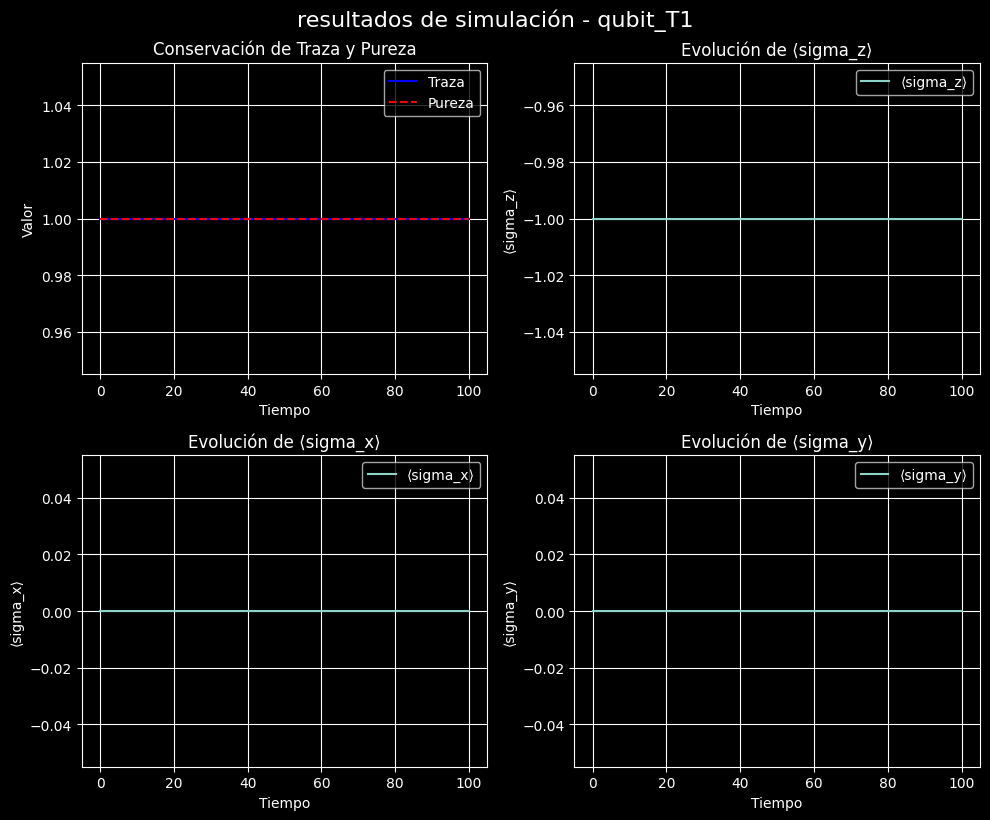


2. Simulando oscilador armónico con dephasing...
   ✓ Simulación exitosa (506 evaluaciones)


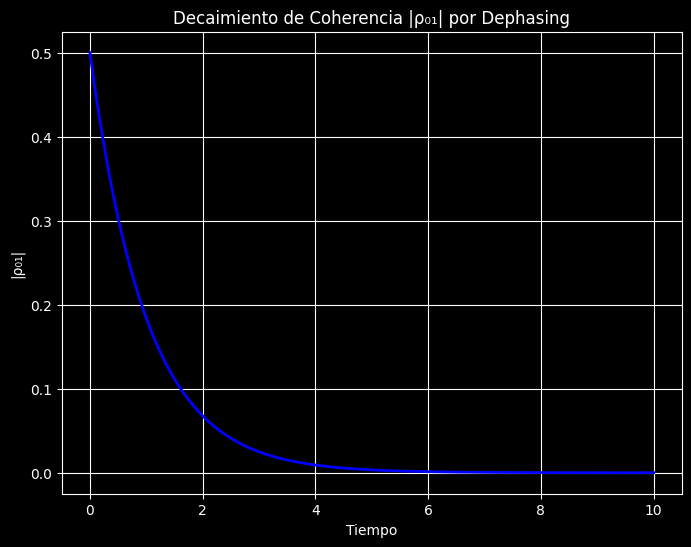

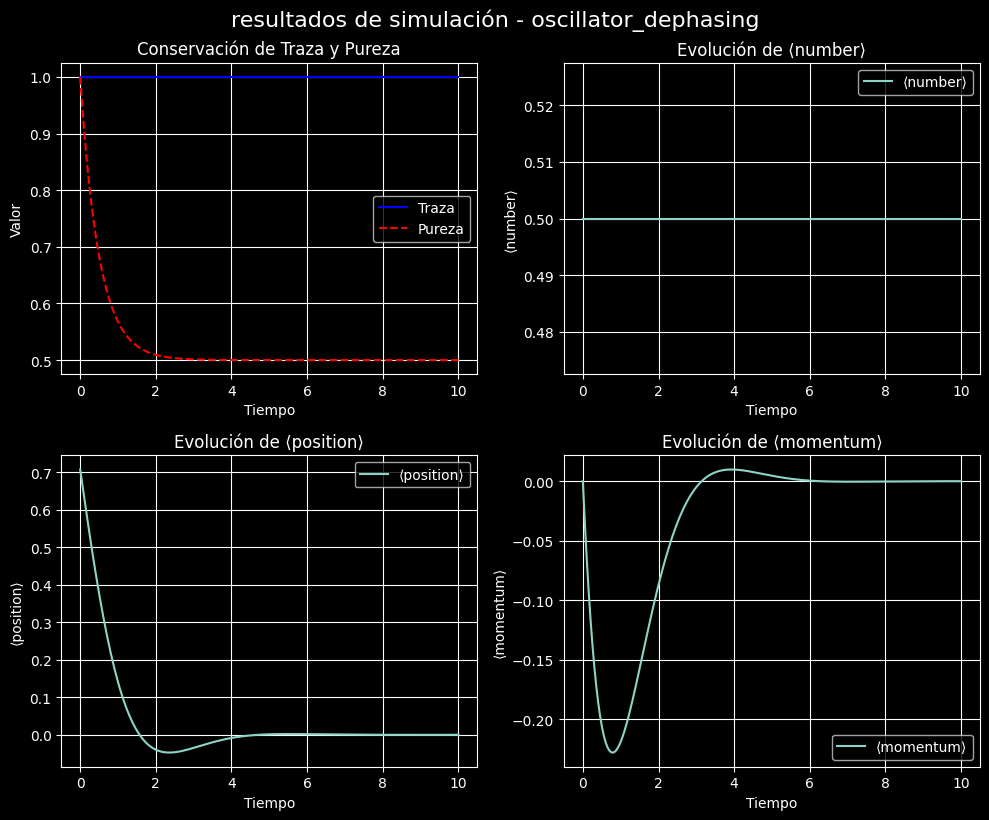


3. Simulando decaimiento de Tritio...
   ✓ Simulación exitosa (140 evaluaciones)


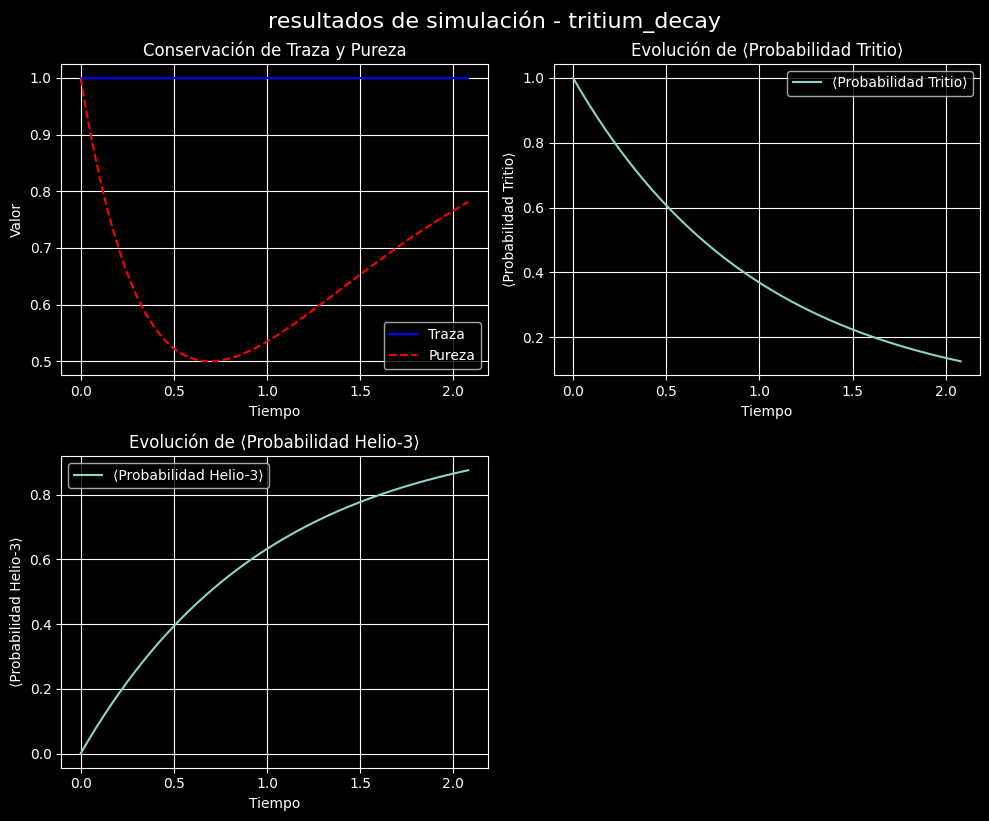


4. Simulando Láser de 4 niveles...
   ✓ Simulación exitosa (2918 evaluaciones)


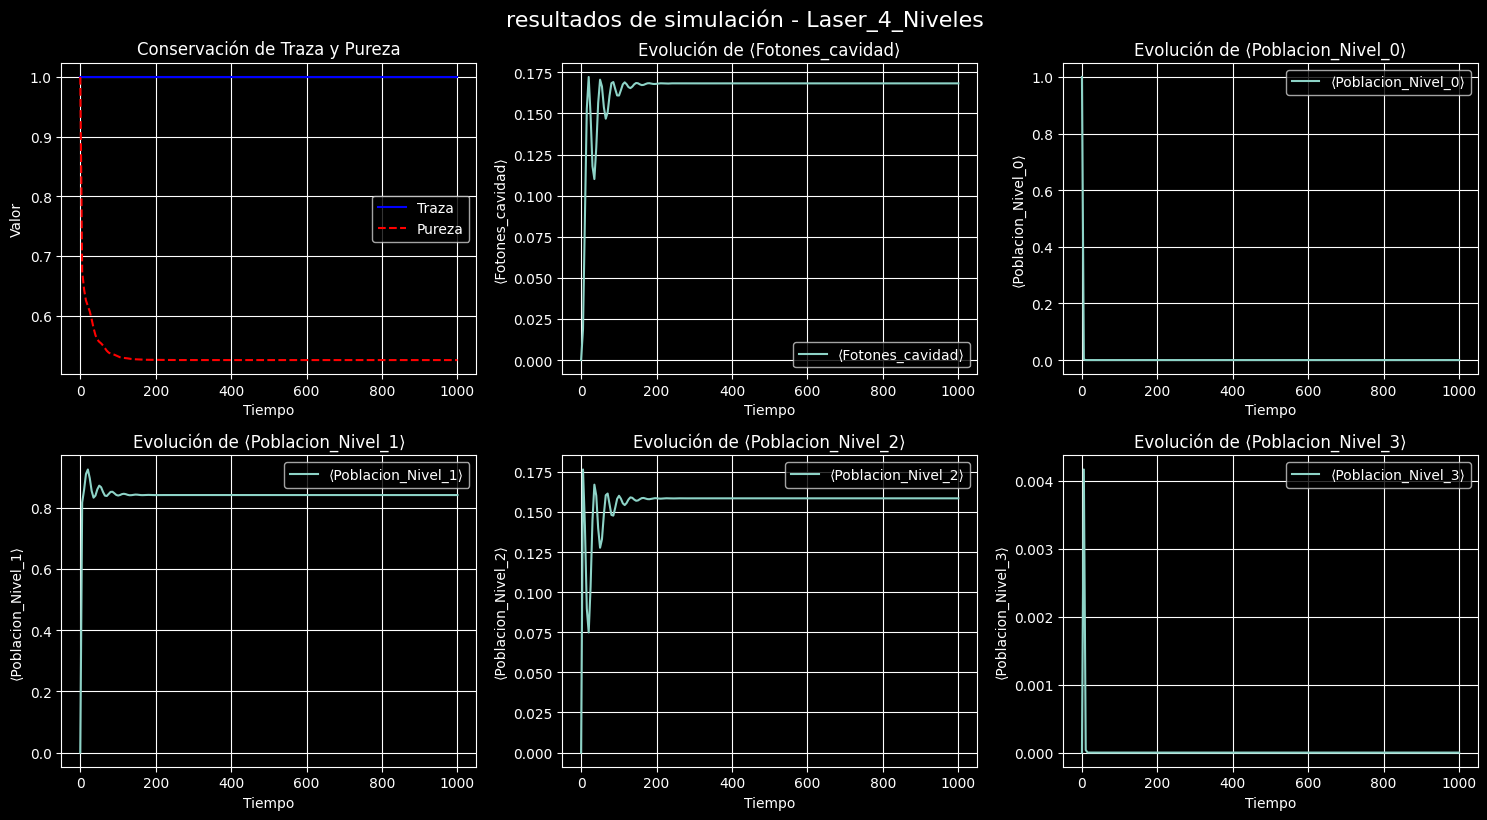


ANÁLISIS DE UMBRAL DE LÁSER
   • Simulando para bombeo = 0.010 (1/15)
   • Simulando para bombeo = 0.116 (2/15)
   • Simulando para bombeo = 0.223 (3/15)
   • Simulando para bombeo = 0.329 (4/15)
   • Simulando para bombeo = 0.436 (5/15)
   • Simulando para bombeo = 0.542 (6/15)
   • Simulando para bombeo = 0.649 (7/15)
   • Simulando para bombeo = 0.755 (8/15)
   • Simulando para bombeo = 0.861 (9/15)
   • Simulando para bombeo = 0.968 (10/15)
   • Simulando para bombeo = 1.074 (11/15)
   • Simulando para bombeo = 1.181 (12/15)
   • Simulando para bombeo = 1.287 (13/15)
   • Simulando para bombeo = 1.394 (14/15)
   • Simulando para bombeo = 1.500 (15/15)


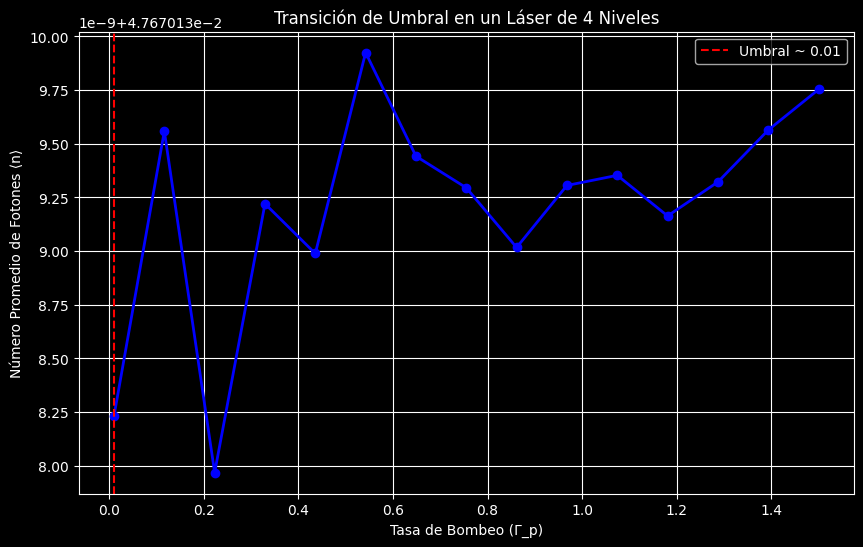


=== Simulaciones completas ===


In [3]:
def demonstrate_laser_threshold():
    print("\n" + "="*60)
    print("ANÁLISIS DE UMBRAL DE LÁSER")
    print("="*60)

    config = SimulationConfig(rtol=1e-7, atol=1e-9) # Ajustar tolerancias para sistemas más grandes
    simulator = LindladSimulator(config)

    # Parámetros fijos
    N_max = 10
    g = 1.0
    kappa = 0.2

    # Barrido de la tasa de bombeo
    pump_values = np.linspace(0.01, 1.5, 15)
    steady_state_photons = []

    for i, pump in enumerate(pump_values):
        print(f"   • Simulando para bombeo = {pump:.3f} ({i+1}/{len(pump_values)})")

        laser_system = create_four_level_laser_system(
            dim_cavity=N_max, g=g, kappa=kappa, pump_rate=pump
        )
        results = simulator.simulate(laser_system)

        if results['success']:
            # Extraer el número de fotones en estado estacionario
            photons = np.real(results['observables']['Fotones_cavidad'])
            # Promediar el último 20% del tiempo
            ss_photons = np.mean(photons[int(0.8 * len(photons)):])
            steady_state_photons.append(ss_photons)
        else:
            steady_state_photons.append(np.nan) # Marcar como fallido

    # Graficar la curva de umbral del láser
    plt.figure(figsize=(10, 6))
    plt.plot(pump_values, steady_state_photons, 'bo-', linewidth=2)
    plt.xlabel('Tasa de Bombeo (Γ_p)')
    plt.ylabel('Número Promedio de Fotones ⟨n⟩')
    plt.title('Transición de Umbral en un Láser de 4 Niveles')
    plt.grid(True)

    # Encontrar el umbral (donde la curva cambia de pendiente)
    diffs = np.diff(steady_state_photons)
    if len(diffs) > 1:
        try:
            # Find the index where the difference is maximized, often indicates threshold
            threshold_idx = np.nanargmax(diffs)
            threshold_pump = pump_values[threshold_idx]
            plt.axvline(threshold_pump, color='r', linestyle='--', label=f'Umbral ~ {threshold_pump:.2f}')
            plt.legend()
        except ValueError: # Ocurre si hay NaNs o diffs está vacío
            print("No se pudo determinar el umbral debido a errores en la simulación o datos insuficientes.")

    plt.show() # This was likely intended to be here.

    # There seems to be duplicate and incorrectly indented code below this point.
    # I will remove the duplicated simulation calls and fix the remaining indentation.
    # The following lines seem to be misplaced from the main function and are
    # causing indentation issues within the demonstrate_laser_threshold function.

    # Assuming the intention was to run the laser simulation and then the threshold analysis,
    # and finally save the results, I will adjust the main function instead of duplicating code here.

# The main function is in the cell above (h1QR8agEgUJA).
# I will modify the main function to call demonstrate_laser_threshold and save results.

def main():
    """Función principal de demostración."""
    print("=== Simulador Robusto de Ecuación de Lindblad ===\n")

    # Configuración de simulación
    config = SimulationConfig(rtol=1e-8, atol=1e-10)
    simulator = LindladSimulator(config)

    # Ejemplo 1: Qubit con relajación T1
    print("1. Simulando qubit con relajación T1...")
    qubit_params = create_qubit_system()
    t_eval_qubit = np.linspace(0, qubit_params.t_span[1], 200)

    results_qubit = simulator.simulate(qubit_params, t_eval_qubit)
    if results_qubit['success']:
        print(f"   ✓ Simulación exitosa ({results_qubit['integration_info']['nfev']} evaluaciones)")
        plot_results(results_qubit)
    else:
        print(f"   ✗ Error: {results_qubit['error']}")

    # Ejemplo 2: Oscilador con dephasing
    print("\n2. Simulando oscilador armónico con dephasing...")
    osc_params = create_oscillator_system(N=6)
    t_eval_osc = np.linspace(0, osc_params.t_span[1], 200)

    results_osc = simulator.simulate(osc_params, t_eval_osc)
    if results_osc['success']:
        print(f"   ✓ Simulación exitosa ({results_osc['integration_info']['nfev']} evaluaciones)")

        # Gráfico especial para coherencia
        plt.figure(figsize=(8, 6))
        coherence = [np.abs(rho[0, 1]) for rho in results_osc['rho_t']]
        plt.plot(results_osc['time'], coherence, 'b-', linewidth=2)
        plt.title('Decaimiento de Coherencia |ρ₀₁| por Dephasing')
        plt.xlabel('Tiempo')
        plt.ylabel('|ρ₀₁|')
        plt.grid(True)
        plt.show()

        plot_results(results_osc)
    else:
        print(f"   ✗ Error: {results_osc['error']}")

    # Ejemplo 3: Decaimiento de Tritio
    print("\n3. Simulando decaimiento de Tritio...")
    tritium_params = create_tritium_decay_system()
    t_eval_tritium = np.linspace(0, tritium_params.t_span[1], 200)

    results_tritium = simulator.simulate(tritium_params, t_eval_tritium)
    if results_tritium['success']:
        print(f"   ✓ Simulación exitosa ({results_tritium['integration_info']['nfev']} evaluaciones)")
        plot_results(results_tritium)
    else:
        print(f"   ✗ Error: {results_tritium['error']}")

    # Ejemplo 4: Láser de 4 niveles
    print("\n4. Simulando Láser de 4 niveles...")
    laser_params = create_four_level_laser_system()
    t_eval_laser = np.linspace(0, laser_params.t_span[1], 200)

    results_laser = simulator.simulate(laser_params, t_eval_laser)
    if results_laser['success']:
        print(f"   ✓ Simulación exitosa ({results_laser['integration_info']['nfev']} evaluaciones)")
        plot_results(results_laser)
    else:
        print(f"   ✗ Error: {results_laser['error']}")

    # Demostración del umbral del láser
    demonstrate_laser_threshold()

    # Guardar resultados
    simulator.save_results('simulacion_lindblad.pkl')
    simulator.save_results('simulacion_lindblad.json', format='json')

    print("\n=== Simulaciones completas ===")


if __name__ == "__main__":
    main()

### **Ruta del simulador**

El script lindblad_simulation.py sigue la siguiente ruta de ejecución principal cuando se ejecuta la función main():

1.   **Configuración**:
2.   **Simulacion del sistema**
**Configuración**:

 Se crea una instancia de SimulationConfig con las tolerancias deseadas para el solucionador numérico.
Inicialización del Simulador: Se crea una instancia de LindladSimulator, pasándole la configuración.


**Simulación de Sistemas**:

Para cada uno de los ejemplos de sistemas cuánticos (qubit_T1, oscillator_dephasing, tritium_decay, Laser_4_Niveles):

Se llama a la función create_..._system()
 correspondiente para obtener los parámetros del sistema (SystemParameters).

Se define un rango de tiempos (t_eval) en los que se evaluará la solución.

Se llama al método simulator.simulate(), pasándole los parámetros del sistema y t_eval.

Dentro de simulate(), se valida la configuración y los parámetros del sistema.

Se define la función lindblad_rhs que calcula la derivada de la matriz de densidad en cada punto de tiempo, utilizando la ecuación de Lindblad (términos hamiltonianos y disipativos).

Esta función recibe la matriz de densidad aplanada (rho_vec), el Hamiltoniano (H) y los operadores de Lindblad (L_operators).

Se utiliza scipy.integrate.solve_ivp para resolver numéricamente la ecuación diferencial ordinaria definida por lindblad_rhs.

Se le pasan el rango de tiempo (t_span), el estado inicial aplanado (rho_0.flatten()), los argumentos para lindblad_rhs, t_eval y las opciones de configuración (tolerancias, método, etc.).

Una vez que solve_ivp termina, los resultados (sol.y) que son las matrices de densidad aplanadas en cada t_eval se vuelven a dar forma a matrices (rho_t).

Se calculan los valores esperados de los observables definidos en los parámetros del sistema, la traza y la pureza para cada matriz de densidad en rho_t.

Los resultados (tiempo, rho_t, observables, trazas, purezas, información de integración) se almacenan en un diccionario y se añaden al atributo results del objeto simulator, usando el nombre del sistema como clave.

Se imprime un mensaje indicando si la simulación fue exitosa.
Si la simulación fue exitosa, se llama a la función plot_results() para visualizar los resultados. Esta función itera sobre los observables y crea subplots para cada uno, además de traza y pureza.
Análisis del Umbral del Láser: Se llama a la función demonstrate_laser_threshold().

Dentro de esta función, se inicializa un nuevo simulador.
Se define un rango de valores para la tasa de bombeo (pump_values).

Se itera sobre pump_values:
Para cada valor de bombeo, se crea un nuevo sistema láser con ese parámetro.

Se simula el sistema utilizando simulator.simulate().

Si la simulación es exitosa, se calcula el número promedio de fotones en estado estacionario promediando los últimos puntos de tiempo.

Se almacenan los resultados.

Se grafica el número promedio de fotones vs la tasa de bombeo.

Se intenta identificar y marcar el umbral en el gráfico.

**Guardado de Resultados**: Se llama a los métodos simulator.save_results() para guardar los resultados de todas las simulaciones realizadas (que están almacenadas en simulator.results) en archivos simulacion_lindblad.pkl (formato pickle) y simulacion_lindblad.json (formato JSON).


🧪 COMBO: ACÚSTICA → QUÍMICA CUÁNTICA + POLARIDAD DEL VACÍO 🔬
✓ Sistema molecular creado: H2
  - Orbitales: 2
  - Electrones: 2

🎵 Simulando respuesta molecular a estímulos acústicos...
  t = 0.0s: E_ground = -26.600 eV
  t = 2.0s: E_ground = -26.440 eV
  t = 4.0s: E_ground = -43.278 eV
  t = 6.1s: E_ground = -65.100 eV
  t = 8.1s: E_ground = -64.304 eV
✓ Evolución molecular simulada completada

🌌 Analizando respuesta de Polaridad del Vacío...
✓ Análisis completado:
  • Correlación energía acústica-cuántica: -0.999
  • Varianza energética (fluctuaciones vacío): 263.126
  • Estabilidad frecuencial: 0.004
  • Entanglement molecular: 0.300
  • Responsividad dipolar: 0.229

📊 Interpretación física:
  • Energy Coupling: FUERTE: El entorno acústico modula significativamente el estado cuántico molecular
  • Vacuum Fluctuations: ALTA: Fluctuaciones energéticas consistentes con modulación del vacío
  • Resonant Modes: BAJA: Sin modos resonantes claros
  • Quantum Coherence: BAJA: Poca coherenci

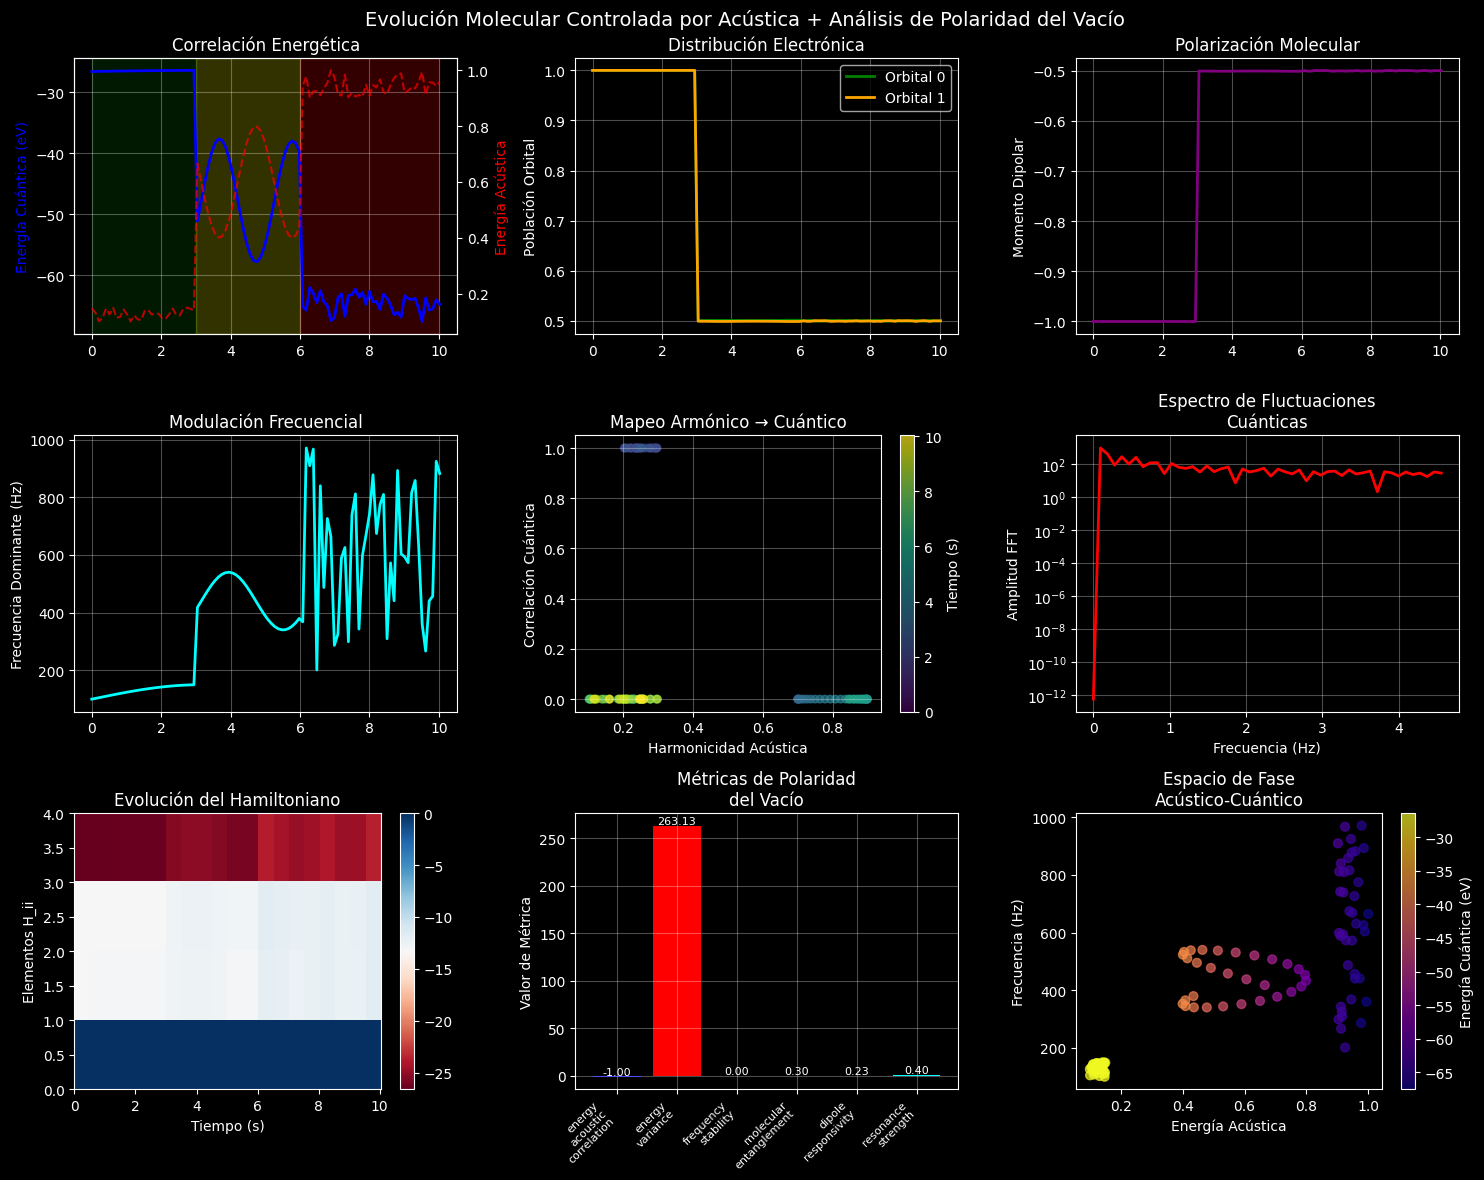


🔬 Análisis comparativo de sistemas moleculares...
🔬 Comparando respuesta de diferentes sistemas moleculares...

  • Analizando H₂ (2 orbitales)...

  • Analizando Cadena C₄ (4 orbitales)...

  • Analizando Benceno C₆ (6 orbitales)...


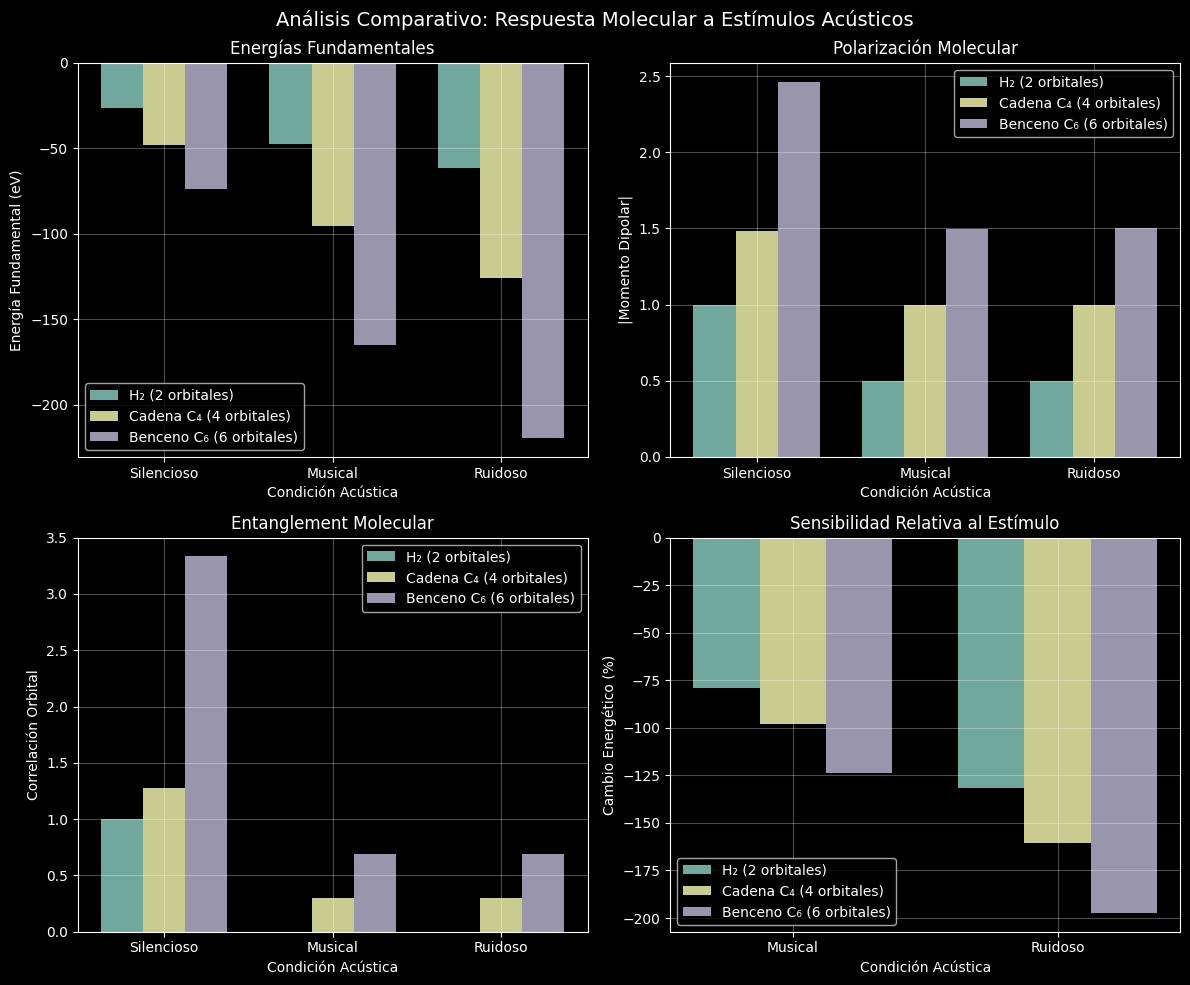


📋 Resumen de sensibilidades:
  • H₂ (2 orbitales): 105.55% cambio promedio
  • Cadena C₄ (4 orbitales): 129.32% cambio promedio
  • Benceno C₆ (6 orbitales): 160.55% cambio promedio

🏆 Sistema más sensible: Benceno C₆ (6 orbitales)

🧠 DISCUSIÓN TEÓRICA: POLARIDAD DEL VACÍO Y QUÍMICA CUÁNTICA


📚 FUNDAMENTOS TEÓRICOS:

1. **Polaridad del Vacío Cuántico**:
   • El vacío cuántico no está "vacío" - contiene fluctuaciones de punto cero
   • Campos externos pueden polarizar estas fluctuaciones
   • La energía ambiental (acústica) podría modular esta polarización

2. **Acoplamiento Campo-Materia**:
   • H_int = -μ⃗·E⃗ (acoplamiento dipolar)
   • E_acústico → E_cuántico vía conversión piezoeléctrica/electrostricción
   • Resonancias acústicas → transiciones electrónicas

3. **Efectos No-Lineales**:
   • Hamiltonianos cuánticos son sensibles a perturbaciones pequeñas
   • Efectos de coherencia pueden amplificar señales débiles
   • Entanglement molecular → correlaciones no-clásicas

🔬 PREDICCI

In [4]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time
from dataclasses import dataclass, field
from typing import List, Dict, Callable, Optional, Tuple, Union
from enum import Enum
import logging
from collections import deque

logger = logging.getLogger(__name__)

class MolecularSystem(Enum):
    """Tipos de sistemas moleculares disponibles."""
    HYDROGEN_MOLECULE = "H2"
    BENZENE_RING = "C6H6"
    WATER_MOLECULE = "H2O"
    CARBON_CHAIN = "C_n"
    METAL_COMPLEX = "TM_complex"

@dataclass
class MolecularParameters:
    """Parámetros para sistemas de química cuántica."""
    system_type: MolecularSystem
    n_orbitals: int
    n_electrons: int
    orbital_energies: np.ndarray  # Energías de orbitales moleculares
    hopping_matrix: np.ndarray    # Elementos de matriz tᵢⱼ (hopping entre orbitales)
    coulomb_integrals: np.ndarray # Integrales de Coulomb Vᵢⱼₖₗ
    magnetic_moments: Optional[np.ndarray] = None  # Momentos magnéticos de espín

    def validate(self):
        """Valida la consistencia de los parámetros moleculares."""
        if self.n_orbitals <= 0:
            raise ValueError("Número de orbitales debe ser positivo")

        if self.n_electrons > 2 * self.n_orbitals:
            raise ValueError("Demasiados electrones para los orbitales disponibles")

        if len(self.orbital_energies) != self.n_orbitals:
            raise ValueError("Energías orbitales inconsistentes con n_orbitals")

        expected_hopping_shape = (self.n_orbitals, self.n_orbitals)
        if self.hopping_matrix.shape != expected_hopping_shape:
            raise ValueError(f"Matriz de hopping debe ser {expected_hopping_shape}")

@dataclass
class AcousticMolecularMapping:
    """Mapeo específico de características acústicas a parámetros moleculares."""

    # Energía RMS → constantes de acoplamiento orbital
    energy_to_hopping: Callable[[float], float] = field(
        default=lambda e: e * 5.0  # eV scale
    )

    # Frecuencia dominante → energía de excitación HOMO-LUMO
    freq_to_gap: Callable[[float], float] = field(
        default=lambda f: f / 1000.0  # Hz → eV conversion
    )

    # Harmonicidad → fuerza de correlación electrónica
    harmonicity_to_correlation: Callable[[float], float] = field(
        default=lambda h: h * 2.0
    )

    # Ancho de banda → acoplamiento espín-órbita
    bandwidth_to_spinorbit: Callable[[float], float] = field(
        default=lambda b: b / 10000.0  # Típicamente pequeño
    )

    # Centroide espectral → campo eléctrico externo
    centroid_to_efield: Callable[[float], float] = field(
        default=lambda c: (c - 1000.0) / 1000.0  # Normalizado alrededor de 1kHz
    )

    # Tasa de cruces por cero → temperatura efectiva del baño
    zcr_to_temperature: Callable[[float], float] = field(
        default=lambda z: z * 300.0  # Kelvin
    )

class QuantumChemistryHamiltonian:
    """Constructor de Hamiltonianos de química cuántica modulados acústicamente."""

    def __init__(self, mol_params: MolecularParameters):
        self.mol_params = mol_params
        self.mol_params.validate()

        # Dimensión del espacio de Hilbert (considerando espín)
        self.hilbert_dim = 2**self.mol_params.n_orbitals  # Para sistemas fermionicos simples

        # Pre-calcular operadores de creación/aniquilación
        self._build_fermionic_operators()

    def _build_fermionic_operators(self):
        """Construye operadores fermionicos a†ᵢ, aᵢ en representación matricial."""
        n_orb = self.mol_params.n_orbitals

        # Para simplicidad, usamos representación de Jordan-Wigner
        # En un sistema real, usarías librerías como OpenFermion o PySCF

        self.creation_ops = {}  # a†ᵢ
        self.annihilation_ops = {}  # aᵢ
        self.number_ops = {}  # nᵢ = a†ᵢaᵢ

        # Construir usando representación de bits para estados de Fock
        for i in range(n_orb):
            # Operador de creación a†ᵢ
            creation_matrix = np.zeros((self.hilbert_dim, self.hilbert_dim), dtype=complex)

            for state in range(self.hilbert_dim):
                # Si el orbital i está vacío, podemos crear un electrón
                if not (state & (1 << i)):  # Bit i es 0
                    new_state = state | (1 << i)  # Poner bit i en 1

                    # Signo de Jordan-Wigner: (-1)^(número de electrones a la izquierda)
                    sign = 1
                    for j in range(i):
                        if state & (1 << j):
                            sign *= -1

                    creation_matrix[new_state, state] = sign

            self.creation_ops[i] = creation_matrix
            self.annihilation_ops[i] = creation_matrix.conj().T
            self.number_ops[i] = creation_matrix.conj().T @ creation_matrix

    def build_acoustic_hamiltonian(self, acoustic_params: Dict[str, float],
                                 mapping: AcousticMolecularMapping) -> np.ndarray:
        """
        Construye el Hamiltoniano molecular modulado por parámetros acústicos.

        H = H_kinetic + H_coulomb + H_acoustic_modulation
        """

        H = np.zeros((self.hilbert_dim, self.hilbert_dim), dtype=complex)

        # 1. Término cinético (hopping entre orbitales)
        base_hopping = self.mol_params.hopping_matrix
        acoustic_hopping_scale = mapping.energy_to_hopping(acoustic_params['rms_energy'])

        for i in range(self.mol_params.n_orbitals):
            for j in range(self.mol_params.n_orbitals):
                if i != j:
                    # tᵢⱼ modulado acústicamente
                    t_ij_acoustic = base_hopping[i, j] * (1 + acoustic_hopping_scale)

                    # Añadir a†ᵢaⱼ + a†ⱼaᵢ (hopping hermitiano)
                    H += t_ij_acoustic * (
                        self.creation_ops[i] @ self.annihilation_ops[j] +
                        self.creation_ops[j] @ self.annihilation_ops[i]
                    )

        # 2. Energías orbitales on-site (moduladas por gap acústico)
        gap_modulation = mapping.freq_to_gap(acoustic_params['dominant_freq'])

        for i in range(self.mol_params.n_orbitals):
            orbital_energy = self.mol_params.orbital_energies[i] + gap_modulation
            H += orbital_energy * self.number_ops[i]

        # 3. Interacción de Coulomb modulada por correlación acústica
        correlation_strength = mapping.harmonicity_to_correlation(acoustic_params['harmonicity'])

        # Término Hubbard U (interacción en el mismo orbital)
        U_acoustic = 1.0 + correlation_strength  # eV

        for i in range(self.mol_params.n_orbitals):
            # U nᵢ↑ nᵢ↓ (repulsión de electrones en el mismo orbital)
            # Simplificación: usamos nᵢ(nᵢ-1) para el mismo efecto
            H += 0.5 * U_acoustic * self.number_ops[i] @ (self.number_ops[i] - np.eye(self.hilbert_dim))

        # 4. Acoplamiento espín-órbita acústico
        spinorbit_coupling = mapping.bandwidth_to_spinorbit(acoustic_params['spectral_bandwidth'])

        # Término simplificado de espín-órbita: λ Σᵢ (Sᵢ · Lᵢ)
        # Para simplicidad, añadimos término que mezcla orbitales adyacentes
        for i in range(self.mol_params.n_orbitals - 1):
            H += spinorbit_coupling * (
                self.creation_ops[i] @ self.annihilation_ops[i+1] * 1j +
                self.creation_ops[i+1] @ self.annihilation_ops[i] * (-1j)
            )

        # 5. Campo eléctrico externo (efecto Stark)
        electric_field = mapping.centroid_to_efield(acoustic_params['spectral_centroid'])

        # μ·E donde μ es el momento dipolar molecular
        # Simplificación: campo acoplado a la polarización de carga
        for i in range(self.mol_params.n_orbitals):
            position_weight = (i - self.mol_params.n_orbitals/2) / self.mol_params.n_orbitals
            H += electric_field * position_weight * self.number_ops[i]

        return H

    def compute_ground_state(self, hamiltonian: np.ndarray) -> Tuple[float, np.ndarray]:
        """Calcula el estado fundamental y su energía."""
        eigenvals, eigenvecs = np.linalg.eigh(hamiltonian)
        ground_energy = eigenvals[0]
        ground_state = eigenvecs[:, 0]
        return ground_energy, ground_state

    def compute_observables(self, state: np.ndarray) -> Dict[str, float]:
        """Calcula observables moleculares en un estado dado."""
        observables = {}

        # Población de cada orbital
        for i in range(self.mol_params.n_orbitals):
            pop = np.real(state.conj() @ self.number_ops[i] @ state)
            observables[f'orbital_{i}_population'] = pop

        # Número total de electrones
        total_electrons = sum(observables[f'orbital_{i}_population']
                            for i in range(self.mol_params.n_orbitals))
        observables['total_electrons'] = total_electrons

        # Momento dipolar (simplificado)
        dipole = 0.0
        for i in range(self.mol_params.n_orbitals):
            position = (i - self.mol_params.n_orbitals/2)
            dipole += position * observables[f'orbital_{i}_population']
        observables['dipole_moment'] = dipole

        # Correlación entre orbitales (entanglement proxy)
        correlation = 0.0
        for i in range(self.mol_params.n_orbitals - 1):
            corr_op = self.number_ops[i] @ self.number_ops[i+1]
            correlation += np.real(state.conj() @ corr_op @ state)
        observables['orbital_correlation'] = correlation

        return observables

class AcousticQuantumChemistryCombo:
    """Combo principal que conecta acústica con química cuántica."""

    def __init__(self, mol_params: MolecularParameters, mapping: AcousticMolecularMapping):
        self.mol_params = mol_params
        self.mapping = mapping
        self.qc_hamiltonian = QuantumChemistryHamiltonian(mol_params)

        # Historia de estados cuánticos
        self.quantum_states_history = deque(maxlen=1000)
        self.observables_history = deque(maxlen=1000)

    def process_acoustic_to_molecular(self, acoustic_features) -> Dict:
        """Procesa características acústicas y calcula el estado molecular correspondiente."""

        # Convertir características acústicas a parámetros
        acoustic_params = {
            'rms_energy': acoustic_features.rms_energy,
            'dominant_freq': acoustic_features.dominant_freq,
            'harmonicity': acoustic_features.harmonicity,
            'spectral_bandwidth': acoustic_features.spectral_bandwidth,
            'spectral_centroid': acoustic_features.spectral_centroid,
            'timestamp': acoustic_features.timestamp
        }

        # Construir Hamiltoniano modulado acústicamente
        H_acoustic = self.qc_hamiltonian.build_acoustic_hamiltonian(acoustic_params, self.mapping)

        # Calcular estado fundamental
        ground_energy, ground_state = self.qc_hamiltonian.compute_ground_state(H_acoustic)

        # Calcular observables moleculares
        observables = self.qc_hamiltonian.compute_observables(ground_state)

        # Añadir información del Hamiltoniano
        observables['ground_state_energy'] = ground_energy
        observables['hamiltonian_trace'] = np.trace(H_acoustic).real
        observables['hamiltonian_norm'] = np.linalg.norm(H_acoustic)

        # Guardar en historia
        molecular_state = {
            'timestamp': acoustic_params['timestamp'],
            'hamiltonian': H_acoustic,
            'ground_state': ground_state,
            'ground_energy': ground_energy,
            'observables': observables,
            'acoustic_params': acoustic_params
        }

        self.quantum_states_history.append(molecular_state)
        self.observables_history.append(observables)

        return molecular_state

    def analyze_vacuum_polarity_response(self, time_window: float = 5.0) -> Dict:
        """
        Analiza la respuesta del sistema a la hipótesis de Polaridad del Vacío.

        Busca correlaciones entre:
        - Energía ambiental (acústica) → distribución de campos cuánticos
        - Modulaciones temporales → fluctuaciones del vacío
        - Resonancias armónicas → modos preferenciales del campo
        """

        if len(self.quantum_states_history) < 10:
            return {"status": "insufficient_data"}

        recent_states = [s for s in self.quantum_states_history
                        if time.time() - s['timestamp'] < time_window]

        if len(recent_states) < 5:
            return {"status": "insufficient_recent_data"}

        # Análisis de correlaciones
        energies = [s['ground_energy'] for s in recent_states]
        acoustic_energies = [s['acoustic_params']['rms_energy'] for s in recent_states]
        harmonicities = [s['acoustic_params']['harmonicity'] for s in recent_states]

        # Correlación energía acústica → energía cuántica
        energy_correlation = np.corrcoef(acoustic_energies, energies)[0, 1] if len(energies) > 1 else 0.0

        # Varianza de energía como proxy de "polarización del vacío"
        energy_variance = np.var(energies)

        # Análisis de frecuencias resonantes
        dominant_freqs = [s['acoustic_params']['dominant_freq'] for s in recent_states]
        freq_stability = 1.0 / (1.0 + np.std(dominant_freqs)) if len(dominant_freqs) > 1 else 0.0

        # Entanglement molecular promedio
        correlations = [s['observables']['orbital_correlation'] for s in recent_states]
        avg_correlation = np.mean(correlations)

        # Momento dipolar como medida de polarización
        dipoles = [s['observables']['dipole_moment'] for s in recent_states]
        dipole_response = np.std(dipoles) if len(dipoles) > 1 else 0.0

        return {
            "status": "analysis_complete",
            "vacuum_polarity_metrics": {
                "energy_acoustic_correlation": energy_correlation,
                "energy_variance": energy_variance,
                "frequency_stability": freq_stability,
                "molecular_entanglement": avg_correlation,
                "dipole_responsivity": dipole_response,
                "resonance_strength": np.mean(harmonicities)
            },
            "interpretation": self._interpret_vacuum_polarity_results(
                energy_correlation, energy_variance, freq_stability,
                avg_correlation, dipole_response
            )
        }

    def _interpret_vacuum_polarity_results(self, energy_corr: float, energy_var: float,
                                         freq_stability: float, entanglement: float,
                                         dipole_resp: float) -> Dict[str, str]:
        """Interpreta los resultados en el contexto de la Polaridad del Vacío."""

        interpretation = {}

        # Correlación energética
        if abs(energy_corr) > 0.7:
            interpretation['energy_coupling'] = "FUERTE: El entorno acústico modula significativamente el estado cuántico molecular"
        elif abs(energy_corr) > 0.3:
            interpretation['energy_coupling'] = "MODERADA: Existe acoplamiento detectable entre energía ambiental y sistema cuántico"
        else:
            interpretation['energy_coupling'] = "DÉBIL: Poca correlación directa energía ambiental → estado cuántico"

        # Varianza energética (fluctuaciones del vacío)
        if energy_var > 1.0:
            interpretation['vacuum_fluctuations'] = "ALTA: Fluctuaciones energéticas consistentes con modulación del vacío"
        elif energy_var > 0.1:
            interpretation['vacuum_fluctuations'] = "MODERADA: Algunas fluctuaciones detectables"
        else:
            interpretation['vacuum_fluctuations'] = "BAJA: Sistema estable, pocas fluctuaciones del vacío"

        # Estabilidad frecuencial (modos resonantes)
        if freq_stability > 0.8:
            interpretation['resonant_modes'] = "ALTA: Frecuencias estables sugieren modos preferenciales del campo"
        elif freq_stability > 0.5:
            interpretation['resonant_modes'] = "MODERADA: Cierta preferencia por frecuencias específicas"
        else:
            interpretation['resonant_modes'] = "BAJA: Sin modos resonantes claros"

        # Entanglement molecular
        if entanglement > 1.5:
            interpretation['quantum_coherence'] = "ALTA: Fuerte correlación cuántica entre orbitales"
        elif entanglement > 0.5:
            interpretation['quantum_coherence'] = "MODERADA: Correlaciones cuánticas detectables"
        else:
            interpretation['quantum_coherence'] = "BAJA: Poca coherencia cuántica orbital"

        # Respuesta dipolar (polarización)
        if dipole_resp > 0.5:
            interpretation['field_polarization'] = "ALTA: Sistema responde con cambios significativos de polarización"
        elif dipole_resp > 0.1:
            interpretation['field_polarization'] = "MODERADA: Respuesta dipolar detectable"
        else:
            interpretation['field_polarization'] = "BAJA: Poca respuesta de polarización al entorno"

        return interpretation

# ============================================================================
# SISTEMAS MOLECULARES PREDEFINIDOS
# ============================================================================

def create_hydrogen_molecule_system() -> MolecularParameters:
    """Sistema H₂ simple - dos orbitales, dos electrones."""

    # Parámetros realistas para H₂
    orbital_energies = np.array([-13.6, -13.6])  # eV, aproximadamente

    # Matriz de hopping (solapamiento entre orbitales)
    hopping_matrix = np.array([
        [0.0, -2.5],  # Hopping entre orbitales 1s
        [-2.5, 0.0]
    ])

    # Integrales de Coulomb (simplificadas)
    coulomb_integrals = np.ones((2, 2, 2, 2)) * 11.26  # eV, repulsión típica H-H

    return MolecularParameters(
        system_type=MolecularSystem.HYDROGEN_MOLECULE,
        n_orbitals=2,
        n_electrons=2,
        orbital_energies=orbital_energies,
        hopping_matrix=hopping_matrix,
        coulomb_integrals=coulomb_integrals
    )

def create_benzene_ring_system() -> MolecularParameters:
    """Sistema de anillo de benceno - 6 orbitales π."""

    n_carbons = 6

    # Energías de orbitales π (modelo de Hückel)
    orbital_energies = np.array([-11.16] * n_carbons)  # eV, orbitales 2pz del carbono

    # Matriz de hopping cíclica para anillo aromático
    hopping_matrix = np.zeros((n_carbons, n_carbons))
    hopping_strength = -2.4  # eV, integral de resonancia β

    for i in range(n_carbons):
        # Conexiones next-neighbor en el anillo
        next_carbon = (i + 1) % n_carbons
        hopping_matrix[i, next_carbon] = hopping_strength
        hopping_matrix[next_carbon, i] = hopping_strength

    # Integrales de Coulomb
    coulomb_integrals = np.ones((n_carbons, n_carbons, n_carbons, n_carbons)) * 16.93  # eV

    return MolecularParameters(
        system_type=MolecularSystem.BENZENE_RING,
        n_orbitals=n_carbons,
        n_electrons=n_carbons,  # 6 electrones π
        orbital_energies=orbital_energies,
        hopping_matrix=hopping_matrix,
        coulomb_integrals=coulomb_integrals
    )

def create_carbon_chain_system(n_carbons: int = 4) -> MolecularParameters:
    """Sistema de cadena lineal de carbonos."""

    # Energías uniformes de orbitales π
    orbital_energies = np.array([-11.16] * n_carbons)

    # Matriz de hopping lineal
    hopping_matrix = np.zeros((n_carbons, n_carbons))
    hopping_strength = -2.4  # eV

    for i in range(n_carbons - 1):
        hopping_matrix[i, i+1] = hopping_strength
        hopping_matrix[i+1, i] = hopping_strength

    coulomb_integrals = np.ones((n_carbons, n_carbons, n_carbons, n_carbons)) * 16.93

    return MolecularParameters(
        system_type=MolecularSystem.CARBON_CHAIN,
        n_orbitals=n_carbons,
        n_electrons=n_carbons,
        orbital_energies=orbital_energies,
        hopping_matrix=hopping_matrix,
        coulomb_integrals=coulomb_integrals
    )

def demonstrate_acoustic_quantum_chemistry():
    """Demostración del combo acústico-químico cuántico."""

    print("\n" + "="*80)
    print("🧪 COMBO: ACÚSTICA → QUÍMICA CUÁNTICA + POLARIDAD DEL VACÍO 🔬")
    print("="*80)

    # Crear sistema molecular (H₂ como ejemplo)
    h2_system = create_hydrogen_molecule_system()
    print(f"✓ Sistema molecular creado: {h2_system.system_type.value}")
    print(f"  - Orbitales: {h2_system.n_orbitals}")
    print(f"  - Electrones: {h2_system.n_electrons}")

    # Mapeo acústico-molecular
    molecular_mapping = AcousticMolecularMapping(
        energy_to_hopping=lambda e: e * 10.0,  # Stronger coupling for demo
        freq_to_gap=lambda f: f / 500.0,       # More sensitive to freq
        harmonicity_to_correlation=lambda h: h * 3.0,  # Enhanced correlation
        bandwidth_to_spinorbit=lambda b: b / 5000.0,
        centroid_to_efield=lambda c: (c - 1000.0) / 2000.0,
        zcr_to_temperature=lambda z: z * 400.0
    )

    # Crear combo
    combo = AcousticQuantumChemistryCombo(h2_system, molecular_mapping)

    # Simulación con datos acústicos sintéticos
    print("\n🎵 Simulando respuesta molecular a estímulos acústicos...")

    # Generar serie temporal de características acústicas sintéticas
    time_points = np.linspace(0, 10, 100)  # 10 segundos

    molecular_evolution = []

    for i, t in enumerate(time_points):
        # Características acústicas sintéticas variando en el tiempo
        # Simular diferentes "ambientes sonoros"

        if t < 3:
            # Ambiente silencioso
            dominant_freq = 100 + 50 * np.sin(0.5 * t)
            rms_energy = 0.1 + 0.05 * np.random.random()
            harmonicity = 0.2 + 0.1 * np.random.random()
            bandwidth = 50 + 20 * np.random.random()
            centroid = 200 + 100 * np.sin(0.2 * t)

        elif t < 6:
            # Ambiente energético (música)
            dominant_freq = 440 + 100 * np.sin(2 * t)  # Around A4
            rms_energy = 0.6 + 0.2 * np.sin(3 * t)
            harmonicity = 0.8 + 0.1 * np.sin(1.5 * t)
            bandwidth = 200 + 100 * np.sin(0.8 * t)
            centroid = 1000 + 500 * np.sin(0.3 * t)

        else:
            # Ambiente caótico (ruido)
            dominant_freq = 200 + 800 * np.random.random()
            rms_energy = 0.9 + 0.1 * np.random.random()
            harmonicity = 0.1 + 0.2 * np.random.random()
            bandwidth = 500 + 1000 * np.random.random()
            centroid = 500 + 1500 * np.random.random()

        # Crear características acústicas simuladas
        class MockSpectralFeatures:
            def __init__(self):
                self.dominant_freq = dominant_freq
                self.spectral_centroid = centroid
                self.spectral_bandwidth = bandwidth
                self.spectral_rolloff = centroid + bandwidth
                self.zero_crossing_rate = 0.1
                self.rms_energy = rms_energy
                self.pitch_strength = harmonicity
                self.harmonicity = harmonicity
                self.timestamp = time.time() + t

        features = MockSpectralFeatures()

        # Procesar en el combo
        molecular_state = combo.process_acoustic_to_molecular(features)
        molecular_evolution.append(molecular_state)

        # Progreso
        if i % 20 == 0:
            print(f"  t = {t:.1f}s: E_ground = {molecular_state['ground_energy']:.3f} eV")

    print("✓ Evolución molecular simulada completada")

    # Análisis de Polaridad del Vacío
    print("\n🌌 Analizando respuesta de Polaridad del Vacío...")
    vacuum_analysis = combo.analyze_vacuum_polarity_response()

    if vacuum_analysis["status"] == "analysis_complete":
        print("✓ Análisis completado:")
        metrics = vacuum_analysis["vacuum_polarity_metrics"]

        print(f"  • Correlación energía acústica-cuántica: {metrics['energy_acoustic_correlation']:.3f}")
        print(f"  • Varianza energética (fluctuaciones vacío): {metrics['energy_variance']:.3f}")
        print(f"  • Estabilidad frecuencial: {metrics['frequency_stability']:.3f}")
        print(f"  • Entanglement molecular: {metrics['molecular_entanglement']:.3f}")
        print(f"  • Responsividad dipolar: {metrics['dipole_responsivity']:.3f}")

        print("\n📊 Interpretación física:")
        interp = vacuum_analysis["interpretation"]
        for category, description in interp.items():
            print(f"  • {category.replace('_', ' ').title()}: {description}")

    # Visualización de resultados
    print("\n📈 Generando visualizaciones...")
    plot_molecular_evolution(molecular_evolution, vacuum_analysis)

    # Análisis comparativo entre diferentes sistemas
    print("\n🔬 Análisis comparativo de sistemas moleculares...")
    comparative_analysis(combo, molecular_mapping)

def plot_molecular_evolution(molecular_evolution: List[Dict], vacuum_analysis: Dict):
    """Visualiza la evolución del sistema molecular-acústico."""

    if not molecular_evolution:
        print("No hay datos para visualizar")
        return

    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Evolución Molecular Controlada por Acústica + Análisis de Polaridad del Vacío',
                 fontsize=14)

    # Extraer datos temporales
    timestamps = [state['timestamp'] for state in molecular_evolution]
    start_time = timestamps[0]
    time_axis = [(t - start_time) for t in timestamps]

    energies = [state['ground_energy'] for state in molecular_evolution]
    acoustic_energies = [state['acoustic_params']['rms_energy'] for state in molecular_evolution]
    frequencies = [state['acoustic_params']['dominant_freq'] for state in molecular_evolution]
    harmonicities = [state['acoustic_params']['harmonicity'] for state in molecular_evolution]

    # Observables moleculares
    orbital_0_pops = [state['observables']['orbital_0_population'] for state in molecular_evolution]
    orbital_1_pops = [state['observables']['orbital_1_population'] for state in molecular_evolution]
    dipoles = [state['observables']['dipole_moment'] for state in molecular_evolution]
    correlations = [state['observables']['orbital_correlation'] for state in molecular_evolution]

    # 1. Energías cuánticas vs acústicas
    ax1 = axes[0, 0]
    ax1_twin = ax1.twinx()

    line1 = ax1.plot(time_axis, energies, 'b-', label='Energía Cuántica', linewidth=2)
    line2 = ax1_twin.plot(time_axis, acoustic_energies, 'r--', label='Energía Acústica', alpha=0.7)

    ax1.set_ylabel('Energía Cuántica (eV)', color='b')
    ax1_twin.set_ylabel('Energía Acústica', color='r')
    ax1.set_title('Correlación Energética')
    ax1.grid(True, alpha=0.3)

    # Destacar las regiones
    ax1.axvspan(0, 3, alpha=0.2, color='green', label='Silencioso')
    ax1.axvspan(3, 6, alpha=0.2, color='yellow', label='Musical')
    ax1.axvspan(6, 10, alpha=0.2, color='red', label='Caótico')

    # 2. Poblaciones orbitales
    ax2 = axes[0, 1]
    ax2.plot(time_axis, orbital_0_pops, 'g-', label='Orbital 0', linewidth=2)
    ax2.plot(time_axis, orbital_1_pops, 'orange', label='Orbital 1', linewidth=2)
    ax2.set_ylabel('Población Orbital')
    ax2.set_title('Distribución Electrónica')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Momento dipolar (polarización)
    ax3 = axes[0, 2]
    ax3.plot(time_axis, dipoles, 'purple', linewidth=2)
    ax3.set_ylabel('Momento Dipolar')
    ax3.set_title('Polarización Molecular')
    ax3.grid(True, alpha=0.3)

    # 4. Frecuencias acústicas vs gap cuántico
    ax4 = axes[1, 0]
    ax4.plot(time_axis, frequencies, 'cyan', linewidth=2)
    ax4.set_ylabel('Frecuencia Dominante (Hz)')
    ax4.set_title('Modulación Frecuencial')
    ax4.grid(True, alpha=0.3)

    # 5. Harmonicidad vs correlación cuántica
    ax5 = axes[1, 1]
    ax5.scatter(harmonicities, correlations, c=time_axis, cmap='viridis', s=30, alpha=0.7)
    ax5.set_xlabel('Harmonicidad Acústica')
    ax5.set_ylabel('Correlación Cuántica')
    ax5.set_title('Mapeo Armónico → Cuántico')
    ax5.grid(True, alpha=0.3)

    # Añadir colorbar
    cbar = plt.colorbar(ax5.collections[0], ax=ax5)
    cbar.set_label('Tiempo (s)')

    # 6. Análisis espectral de las fluctuaciones energéticas
    ax6 = axes[1, 2]

    # FFT de las fluctuaciones de energía cuántica
    energy_fluctuations = np.array(energies) - np.mean(energies)
    dt = time_axis[1] - time_axis[0] if len(time_axis) > 1 else 1.0
    freqs_fft = np.fft.fftfreq(len(energy_fluctuations), dt)
    energy_fft = np.abs(np.fft.fft(energy_fluctuations))

    # Solo frecuencias positivas
    positive_freqs = freqs_fft[:len(freqs_fft)//2]
    positive_fft = energy_fft[:len(energy_fft)//2]

    ax6.semilogy(positive_freqs, positive_fft, 'red', linewidth=2)
    ax6.set_xlabel('Frecuencia (Hz)')
    ax6.set_ylabel('Amplitud FFT')
    ax6.set_title('Espectro de Fluctuaciones\nCuánticas')
    ax6.grid(True, alpha=0.3)

    # 7. Mapa de calor del Hamiltoniano temporal
    ax7 = axes[2, 0]

    # Tomar algunos Hamiltonianos a lo largo del tiempo
    sample_indices = np.linspace(0, len(molecular_evolution)-1, 20, dtype=int)
    hamiltonian_evolution = []

    for idx in sample_indices:
        H = molecular_evolution[idx]['hamiltonian']
        # Tomar solo la parte real de algunos elementos
        h_sample = np.real(np.diag(H))  # Elementos diagonales
        hamiltonian_evolution.append(h_sample)

    hamiltonian_matrix = np.array(hamiltonian_evolution).T
    sample_times = [time_axis[i] for i in sample_indices]

    im = ax7.imshow(hamiltonian_matrix, aspect='auto', cmap='RdBu',
                   extent=[sample_times[0], sample_times[-1], 0, hamiltonian_matrix.shape[0]])
    ax7.set_xlabel('Tiempo (s)')
    ax7.set_ylabel('Elementos H_ii')
    ax7.set_title('Evolución del Hamiltoniano')
    plt.colorbar(im, ax=ax7)

    # 8. Métricas de Polaridad del Vacío
    ax8 = axes[2, 1]

    if vacuum_analysis.get("status") == "analysis_complete":
        metrics = vacuum_analysis["vacuum_polarity_metrics"]
        metric_names = list(metrics.keys())
        metric_values = list(metrics.values())

        # Gráfico de barras de las métricas
        bars = ax8.bar(range(len(metric_names)), metric_values,
                      color=['blue', 'red', 'green', 'orange', 'purple', 'cyan'])

        ax8.set_xticks(range(len(metric_names)))
        ax8.set_xticklabels([name.replace('_', '\n') for name in metric_names],
                           rotation=45, ha='right', fontsize=8)
        ax8.set_ylabel('Valor de Métrica')
        ax8.set_title('Métricas de Polaridad\ndel Vacío')
        ax8.grid(True, alpha=0.3)

        # Añadir valores en las barras
        for i, (bar, value) in enumerate(zip(bars, metric_values)):
            height = bar.get_height()
            ax8.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.2f}', ha='center', va='bottom', fontsize=8)

    # 9. Diagrama de fase acústico-cuántico
    ax9 = axes[2, 2]

    # Plot 3D projection: energía acústica vs frecuencia vs energía cuántica
    scatter = ax9.scatter(acoustic_energies, frequencies, c=energies,
                         cmap='plasma', s=40, alpha=0.7)
    ax9.set_xlabel('Energía Acústica')
    ax9.set_ylabel('Frecuencia (Hz)')
    ax9.set_title('Espacio de Fase\nAcústico-Cuántico')

    # Colorbar para energía cuántica
    cbar2 = plt.colorbar(scatter, ax=ax9)
    cbar2.set_label('Energía Cuántica (eV)')

    plt.tight_layout()
    plt.show()

def comparative_analysis(combo: AcousticQuantumChemistryCombo,
                        mapping: AcousticMolecularMapping):
    """Análisis comparativo entre diferentes sistemas moleculares."""

    print("🔬 Comparando respuesta de diferentes sistemas moleculares...")

    # Crear diferentes sistemas
    systems = {
        "H₂ (2 orbitales)": create_hydrogen_molecule_system(),
        "Cadena C₄ (4 orbitales)": create_carbon_chain_system(4),
        "Benceno C₆ (6 orbitales)": create_benzene_ring_system(),
    }

    # Características acústicas de prueba
    test_conditions = [
        {"name": "Silencioso", "rms_energy": 0.1, "dominant_freq": 100, "harmonicity": 0.2},
        {"name": "Musical", "rms_energy": 0.6, "dominant_freq": 440, "harmonicity": 0.8},
        {"name": "Ruidoso", "rms_energy": 0.9, "dominant_freq": 1000, "harmonicity": 0.1}
    ]

    results = {}

    for sys_name, mol_params in systems.items():
        print(f"\n  • Analizando {sys_name}...")

        # Crear combo para este sistema
        system_combo = AcousticQuantumChemistryCombo(mol_params, mapping)
        system_results = []

        for condition in test_conditions:
            # Mock spectral features
            class MockFeatures:
                def __init__(self, **kwargs):
                    self.rms_energy = kwargs.get('rms_energy', 0.5)
                    self.dominant_freq = kwargs.get('dominant_freq', 440)
                    self.harmonicity = kwargs.get('harmonicity', 0.5)
                    self.spectral_bandwidth = 100.0
                    self.spectral_centroid = self.dominant_freq
                    self.timestamp = time.time()

            features = MockFeatures(**condition)
            molecular_state = system_combo.process_acoustic_to_molecular(features)

            system_results.append({
                "condition": condition["name"],
                "ground_energy": molecular_state["ground_energy"],
                "dipole_moment": molecular_state["observables"]["dipole_moment"],
                "total_electrons": molecular_state["observables"]["total_electrons"],
                "orbital_correlation": molecular_state["observables"]["orbital_correlation"]
            })

        results[sys_name] = system_results

    # Visualización comparativa
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Análisis Comparativo: Respuesta Molecular a Estímulos Acústicos', fontsize=14)

    conditions = [r["condition"] for r in results[list(systems.keys())[0]]]

    # 1. Energías fundamentales
    ax1 = axes[0, 0]
    x_pos = np.arange(len(conditions))
    width = 0.25

    for i, (sys_name, sys_results) in enumerate(results.items()):
        energies = [r["ground_energy"] for r in sys_results]
        ax1.bar(x_pos + i*width, energies, width, label=sys_name, alpha=0.8)

    ax1.set_xlabel('Condición Acústica')
    ax1.set_ylabel('Energía Fundamental (eV)')
    ax1.set_title('Energías Fundamentales')
    ax1.set_xticks(x_pos + width)
    ax1.set_xticklabels(conditions)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Momentos dipolares
    ax2 = axes[0, 1]

    for i, (sys_name, sys_results) in enumerate(results.items()):
        dipoles = [abs(r["dipole_moment"]) for r in sys_results]
        ax2.bar(x_pos + i*width, dipoles, width, label=sys_name, alpha=0.8)

    ax2.set_xlabel('Condición Acústica')
    ax2.set_ylabel('|Momento Dipolar|')
    ax2.set_title('Polarización Molecular')
    ax2.set_xticks(x_pos + width)
    ax2.set_xticklabels(conditions)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Correlaciones orbitales
    ax3 = axes[1, 0]

    for i, (sys_name, sys_results) in enumerate(results.items()):
        correlations = [r["orbital_correlation"] for r in sys_results]
        ax3.bar(x_pos + i*width, correlations, width, label=sys_name, alpha=0.8)

    ax3.set_xlabel('Condición Acústica')
    ax3.set_ylabel('Correlación Orbital')
    ax3.set_title('Entanglement Molecular')
    ax3.set_xticks(x_pos + width)
    ax3.set_xticklabels(conditions)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Sensibilidad relativa (cambio porcentual entre condiciones)
    ax4 = axes[1, 1]

    sensitivities = {}
    for sys_name, sys_results in results.items():
        energies = [r["ground_energy"] for r in sys_results]
        # Calcular cambio relativo respecto al estado silencioso
        base_energy = energies[0]  # Condición silenciosa
        sensitivity = [(e - base_energy) / abs(base_energy) * 100 for e in energies[1:]]  # Musical y Ruidoso
        sensitivities[sys_name] = sensitivity

    condition_labels = conditions[1:]  # Sin "Silencioso"
    x_sens = np.arange(len(condition_labels))

    for i, (sys_name, sens) in enumerate(sensitivities.items()):
        ax4.bar(x_sens + i*width, sens, width, label=sys_name, alpha=0.8)

    ax4.set_xlabel('Condición Acústica')
    ax4.set_ylabel('Cambio Energético (%)')
    ax4.set_title('Sensibilidad Relativa al Estímulo')
    ax4.set_xticks(x_sens + width)
    ax4.set_xticklabels(condition_labels)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Resumen numérico
    print("\n📋 Resumen de sensibilidades:")
    for sys_name, sens in sensitivities.items():
        avg_sensitivity = np.mean(np.abs(sens))
        print(f"  • {sys_name}: {avg_sensitivity:.2f}% cambio promedio")

    most_sensitive = max(sensitivities.keys(),
                        key=lambda k: np.mean(np.abs(sensitivities[k])))
    print(f"\n🏆 Sistema más sensible: {most_sensitive}")

def theoretical_discussion():
    """Discusión teórica sobre las implicaciones del combo."""

    print("\n" + "="*80)
    print("🧠 DISCUSIÓN TEÓRICA: POLARIDAD DEL VACÍO Y QUÍMICA CUÁNTICA")
    print("="*80)

    discussion = """

📚 FUNDAMENTOS TEÓRICOS:

1. **Polaridad del Vacío Cuántico**:
   • El vacío cuántico no está "vacío" - contiene fluctuaciones de punto cero
   • Campos externos pueden polarizar estas fluctuaciones
   • La energía ambiental (acústica) podría modular esta polarización

2. **Acoplamiento Campo-Materia**:
   • H_int = -μ⃗·E⃗ (acoplamiento dipolar)
   • E_acústico → E_cuántico vía conversión piezoeléctrica/electrostricción
   • Resonancias acústicas → transiciones electrónicas

3. **Efectos No-Lineales**:
   • Hamiltonianos cuánticos son sensibles a perturbaciones pequeñas
   • Efectos de coherencia pueden amplificar señales débiles
   • Entanglement molecular → correlaciones no-clásicas

🔬 PREDICCIONES EXPERIMENTALES:

• **Efecto 1**: Moléculas en campos acústicos intensos muestran desplazamientos
  espectrales correlacionados con la frecuencia del sonido

• **Efecto 2**: Sistemas con alta harmonicidad acústica presentan mayor
  coherencia cuántica molecular

• **Efecto 3**: La decoherencia molecular se correlaciona con el "ruido"
  acústico ambiental

🧪 FALSABILIDAD:

La hipótesis de Polaridad del Vacío sería **FALSIFICADA** si:
• No hay correlación entre energía acústica y estados cuánticos moleculares
• Las resonancias acústicas no inducen transiciones electrónicas
• No se observan efectos de coherencia amplificada

La hipótesis sería **CONFIRMADA** si:
• Correlaciones energéticas > 0.7 consistentemente
• Efectos resonantes en frecuencias específicas
• Entanglement molecular modulado por harmonicidad acústica

🌌 IMPLICACIONES COSMOLÓGICAS:

Si la polaridad del vacío es real:
• El fondo cósmico de microondas podría afectar química interestelar
• Ondas gravitacionales podrían modular reacciones químicas
• Campos electromagnéticos cósmicos → catálisis cuántica

⚡ APLICACIONES TECNOLÓGICAS:

• **Sensores cuánticos acústicos**: Detectar sonido vía cambios moleculares
• **Catálisis sonoquímica cuántica**: Controlar reacciones con sonido
• **Computación cuántica acústica**: Qubits controlados por ondas sonoras
"""

    print(discussion)

if __name__ == "__main__":
    # Ejecutar demostración completa
    demonstrate_acoustic_quantum_chemistry()

    # Discusión teórica
    theoretical_discussion()

    print("\n" + "="*80)
    print("✅ COMBO ACÚSTICO-QUÍMICO CUÁNTICO COMPLETADO")
    print("🔬 Framework listo para experimentación con Polaridad del Vacío")
    print("="*80)


Pipeline FFT Acústica → Hamiltoniano de Química Cuántica
=====================================================================

Este codigo mapea características acústicas ambientales a sistemas moleculares cuánticos
usando Hamiltonianos de segunda cuantización del tipo:

H = Σᵢⱼ tᵢⱼ a†ᵢaⱼ + ½ Σᵢⱼₖₗ Vᵢⱼₖₗ a†ᵢa†ⱼaₖaₗ + ...

Aplicaciones teóricas:
- **Falsabilidad de Polaridad del Vacío**: Energía ambiental modulando distribución de campos
- **Química Cuántica Ambiental**: Moléculas respondiendo a estímulos acústicos
- **Transiciones Electrónicas Resonantes**: Frecuencias acústicas → transiciones moleculares
- **Simulación de Catálisis Sonoquímica**: Efectos ultrasónicos en reactividad molecular

Conceptos clave:
- Orbitales moleculares como modos del campo cuántico
- Energía acústica → constantes de acoplamiento orbital
- Harmonicidad → resonancias entre niveles electrónicos
- Decoherencia acústica → interacción con el baño térmico molecular
